## Target Process Simulation

We have a periodic $L$-lattice with an initial configuration of $\{1, \cdots, 1\}$. From a site with $k$ dots to a site with $\ell$ dots, the rate of transfer is given by $W_{k,\ell} = (1-\delta_{k,0})(1-\delta_{\ell,0})$, yet this transfer does not effectively cooperate with the known factorization schemes in target-process theory. Hence, we consider, instead, the rate $$W_{k,\ell} = (1-\delta_{k,0})v_\ell,$$ where $v_\ell = e^{-\beta}$ if $\ell$ is zero and $v_\ell=1$ otherwise. The primary prediction of this form is $$\mathbb{P}(\{n_k\})=Z_{L,N}^{-1} e^{-N_s\beta},$$ where $N_s$ is the number of stacks, i.e., the number of sites with dots on them. The purpose of this simulation is to test this hypothesis.

Running a simulation $M$ times should result in $$\text{\# of outcomes with }N_s\text{ stacks}\propto e^{-N_s\beta},$$ where each simulation is ran long enough as to reach a final state.

In [1]:
import random
import json
import numpy as np
import math
from math import comb
import matplotlib.pyplot as plt
from tqdm import tqdm

plt.rcParams['text.usetex'] = True  # Enable LaTeX rendering
plt.rcParams['font.family'] = 'serif'
plt.rcParams['figure.dpi'] = 300

### `Configuration` Class

The abstract representation of a particular arrangement of particles around a circle of $L$ sites, equipped with the appropriate behaviors as methods.

In [155]:
class Configuration:
    ################################# INITIALIZATION #################################
    # initializes a configuration with a given number of sites and one particle per site
    def __init__(self, num_of_sites):
        self.num_of_sites = num_of_sites
        self.data = [1] * num_of_sites

    def from_string(self, config_string):
        string_to_list = json.loads(config_string)
        self.num_of_sites = len(string_to_list)
        self.data = [int(x) for x in string_to_list]
    
    ##################################### GETTERS #####################################
    # returns number of particles in the configuration (equal to number of sites, in default case)
    def get_num_of_particles(self):
        return sum(self.data)
    
    # returns number of empty sites in the configuration
    def get_num_of_empty_sites(self):
        return self.data.count(0)
    
    # returns number of occupied sites in the configuration, correlated sometimes with the number of "stacks"
    def get_num_of_occupied_sites(self):
        return self.num_of_sites - self.get_num_of_empty_sites()
    
    # returns a list of indices of empty sites
    def get_empty_sites(self):
        return [i for i, x in enumerate(self.data) if x == 0]
    
    # returns a list of indices of occupied sites
    def get_occupied_sites(self):
        return [i for i, x in enumerate(self.data) if x != 0]

    # returns a list of indices of occupied sites that have at least one neighbor occupied
    def get_occupied_sites_with_neighbors(self):
        return [
            i for i in self.get_occupied_sites() if
            (self.data[(i - 1) % self.num_of_sites] != 0 or self.data[(i + 1) % self.num_of_sites] != 0)
        ]
    
    # returns a list of occupied neighbors of a given site index
    def get_occupied_neighbors(self, index):
        left_neighbor = (index - 1) % self.num_of_sites
        right_neighbor = (index + 1) % self.num_of_sites
        return [
            i for i in [left_neighbor, right_neighbor] if self.data[i] != 0
        ]
        
    # returns a list of all possible pairs of departure and arrival sites, i.e., those pairs where the first index is an occupied site
    # with at least one neighbor occupied, and the second index is one of the occupied neighbors of the first index
    def get_all_departure_arrival_pairs(self):
        pairs = []
        for departure_index in self.get_occupied_sites_with_neighbors():
            occupied_neighbors = self.get_occupied_neighbors(departure_index)
            for arrival_index in occupied_neighbors:
                pairs.append((departure_index, arrival_index))
        return pairs
    
    # functions that provide statistical measures of the system as a measure for steady-state behavior
    def probability_of_k_particles_at_a_site(self, k):
        number_of_sites_with_k_particles = 0
        for site in self.data:
            if site == k:
                number_of_sites_with_k_particles += 1
        return number_of_sites_with_k_particles / len(self.data)

    ##################################### SELECTORS #####################################
    # selects a random index of an occupied site
    def select_random_occupied_site(self):
        occupied_indices = self.get_occupied_sites()
        if occupied_indices:
            return random.choice(occupied_indices)
        else:
            raise ValueError("No occupied sites available to select from.")
    
    # selects a random index of an occupied site, with the constraint that at least one neighbor must be occupied
    # i.e., the selected site must have at least one neighbor that is occupied. this will be the departure site.
    def select_random_occupied_site_with_neighbor(self):
        occupied_indices = self.get_occupied_sites()
        if len(occupied_indices) == 0:
            raise ValueError("No occupied sites available to select from.")
        
        occupied_indices_with_neighbors = self.get_occupied_sites_with_neighbors()
        if len(occupied_indices_with_neighbors) == 0:
            return -1   # represents that the process cannot continue, as no occupied site has a neighbor
                        # i.e, we have reached an absorbing state
        else:
            return random.choice(occupied_indices_with_neighbors)

    # selects a pair of departure and arrival sites, i.e., a pair of indices such that the first index is an occupied site
    # with at least one neighbor occupied, and the second index is one of the occupied neighbors of the first index
    def select_departure_and_arrival_sites(self):
        departure_index = self.select_random_occupied_site_with_neighbor()
        if departure_index == -1:
            return -1, -1 # indicates that the process cannot continue, as no occupied site has a neighbor
        
        occupied_neighbors = self.get_occupied_neighbors(departure_index)
        if len(occupied_neighbors) == 0:
            raise ValueError("No occupied neighbors available for the selected departure site.")
        
        arrival_index = random.choice(occupied_neighbors)
        return departure_index, arrival_index
    
    def select_departure_and_arrival_sites_uniformly(self):
        pairs = self.get_all_departure_arrival_pairs()
        if not pairs:
            return -1, -1
        departure_index, arrival_index = random.choice(pairs)
        return departure_index, arrival_index
    
    ##################################### EVOLVERS #####################################
    # evolves the configuration by moving a particle from a departure site to an arrival site
    def evolve(self):
        departure_index, arrival_index = self.select_departure_and_arrival_sites_uniformly()
        if departure_index == -1:
            return False # indicates that the process cannot continue, as no occupied site has a neighbor
        
        # move the particle from departure to arrival
        self.data[departure_index] -= 1
        self.data[arrival_index] += 1
        return True
    
    # evolves the configuration until it reaches an absorbing state, i.e., no occupied site has a neighbor
    # can shoot off to infinity in rare cases, but practically it will reach an absorbing state in finite time
    def evolve_until_absorbing_state(self):
        time_steps = 0
        while self.evolve():
            time_steps += 1
        return time_steps, self.data

    ##################################### CHECKERS #####################################
    # the purpose of this section of methods is to check if two different configurations are equal,
    # up to rotational and reflectional symmetry (i.e., under the action of the dihedral group D_2n)
    def is_equal_to(self, other):
        if self.num_of_sites != other.num_of_sites:
            return False
        
        for _ in range(self.num_of_sites):
            if self.data == other.data:
                return True
            # rotate the other configuration
            other.data = other.data[1:] + other.data[:1]
        
        # check reflection
        reflected_other = other.data[::-1]
        for _ in range(self.num_of_sites):
            if self.data == reflected_other:
                return True
            # rotate the reflected configuration
            reflected_other = reflected_other[1:] + reflected_other[:1]

        # # naive approach to check equality ignoring symmetry
        # if self.data == other.data:
        #     return True
        
        return False
        

### `ManyConfigurationExperiment` Class

A class for running dynamical experiments on many configurations and for collecting and processing their data.

In [162]:
class ManyConfigurationExperiment:
    def __init__(self, num_of_sites):
        self.num_of_sites = num_of_sites
        self.data = {                                           # dictionary to store configurations and their counts, 
                                                # where keys are configurations as strings and values are an array of time steps to reach absorbing state
            str([num_of_sites] + [0]*(num_of_sites - 1)): []    # initial configuration with all particles at the first site
        }
    
    def run_trial(self):
        config = Configuration(self.num_of_sites)
        time_steps, data = config.evolve_until_absorbing_state()

        configuration_already_exists = False
        for key in self.data.keys():
            existing_config = Configuration(self.num_of_sites)
            existing_config.from_string(key)
            if existing_config.is_equal_to(config):
                self.data[key].append(time_steps)
                configuration_already_exists = True
                break
        
        if not configuration_already_exists:
            self.data[str(config.data)] = [time_steps]
    
    def run_trials(self, num_of_trials):
        for _ in tqdm(range(num_of_trials)):
            self.run_trial()
    
    def get_data_of_k_occupied_sites(self, k):
        new_data = {}
        for key, time_steps in self.data.items():
            config = Configuration(self.num_of_sites)
            config.from_string(key)
            if config.get_num_of_occupied_sites() == k:
                new_data[key] = time_steps
        return new_data

    def get_num_of_trials(self):
        return sum(len(time_steps) for time_steps in self.data.values())
    
    def get_number_of_events_in_each_configuration(self, map=None):
        if map is None:
            map = {key: len(value) for key, value in self.data.items()}
        else:
            map = {key: len(value) for key, value in map.items()}
        return map

    def get_probabilities_of_each_configuration(self, map=None):
        if map is None:
            map = {key: len(value)/self.get_num_of_trials() for key, value in self.data.items()}
        else:
            map = {key: len(value)/self.get_num_of_trials() for key, value in map.items()}
        return map
    
    def get_number_of_absorbing_states(self):
        return len(self.data)
    
    def get_probability_of_k_occupied_sites(self, k):
        total_trials = self.get_num_of_trials()
        if total_trials == 0:
            return 0
        k_data = self.get_data_of_k_occupied_sites(k)
        k_trials = sum(len(time_steps) for time_steps in k_data.values())
        return k_trials / total_trials if k_trials > 0 else 0
    
    def get_most_probable_absorbing_state(self):
        probabilities = self.get_probabilities_of_each_configuration()
        most_probable_state = max(probabilities, key=probabilities.get)
        return most_probable_state, probabilities[most_probable_state]

### Experiment

In [182]:
Sites = 8                           # number of sites
Trials = 1_000_000                     # number of trials to run

# Data = {                                # dictionary to store configurations and their counts, 
#                                         # where keys are configurations as strings and values are an array of time steps to reach absorbing state
#     str([Sites] + [0]*(Sites - 1)): []  # initial configuration with all particles at the first site
# }

Data = ManyConfigurationExperiment(Sites)
Data.run_trials(Trials)

100%|██████████| 1000000/1000000 [01:04<00:00, 15479.16it/s]


In [183]:
print("Number of absorbing states reached:", Data.get_number_of_absorbing_states())

Number of absorbing states reached: 45


In [165]:
Data.get_probabilities_of_each_configuration(
    # Data.get_data_of_k_occupied_sites(2)
)

{'[8, 0, 0, 0, 0, 0, 0, 0]': 3e-06,
 '[0, 1, 0, 3, 0, 0, 4, 0]': 0.004439,
 '[4, 0, 0, 3, 0, 0, 1, 0]': 0.001418,
 '[2, 0, 3, 0, 0, 3, 0, 0]': 0.012194,
 '[3, 0, 1, 0, 4, 0, 0, 0]': 0.003713,
 '[3, 0, 0, 3, 0, 0, 2, 0]': 0.012104,
 '[0, 2, 0, 2, 0, 0, 4, 0]': 0.007822,
 '[0, 2, 0, 4, 0, 0, 0, 2]': 0.003738,
 '[4, 0, 0, 2, 0, 0, 2, 0]': 0.00377,
 '[0, 1, 0, 2, 0, 2, 0, 3]': 0.005016,
 '[3, 0, 0, 0, 3, 0, 2, 0]': 0.005328,
 '[1, 0, 3, 0, 1, 0, 3, 0]': 0.004294,
 '[0, 0, 3, 0, 0, 3, 0, 2]': 0.012232,
 '[1, 0, 0, 3, 0, 4, 0, 0]': 0.00129,
 '[3, 0, 0, 3, 0, 2, 0, 0]': 0.012459,
 '[2, 0, 3, 0, 2, 0, 1, 0]': 0.005065,
 '[2, 0, 0, 0, 4, 0, 2, 0]': 0.003645,
 '[0, 4, 0, 0, 2, 0, 2, 0]': 0.007825,
 '[0, 1, 0, 4, 0, 2, 0, 1]': 0.000201,
 '[0, 0, 4, 0, 0, 3, 0, 1]': 0.00443,
 '[0, 3, 0, 2, 0, 3, 0, 0]': 0.005404,
 '[0, 2, 0, 3, 0, 0, 3, 0]': 0.012474,
 '[0, 2, 0, 3, 0, 0, 0, 3]': 0.005237,
 '[4, 0, 0, 0, 4, 0, 0, 0]': 0.004819,
 '[4, 0, 0, 3, 0, 1, 0, 0]': 0.004347,
 '[3, 0, 0, 2, 0, 3, 0, 0]': 0.

#### **Probabilities of Absorbing States with Same $N_s$**

Text(0, 0.5, 'Probability of Reaching Absorbing State')

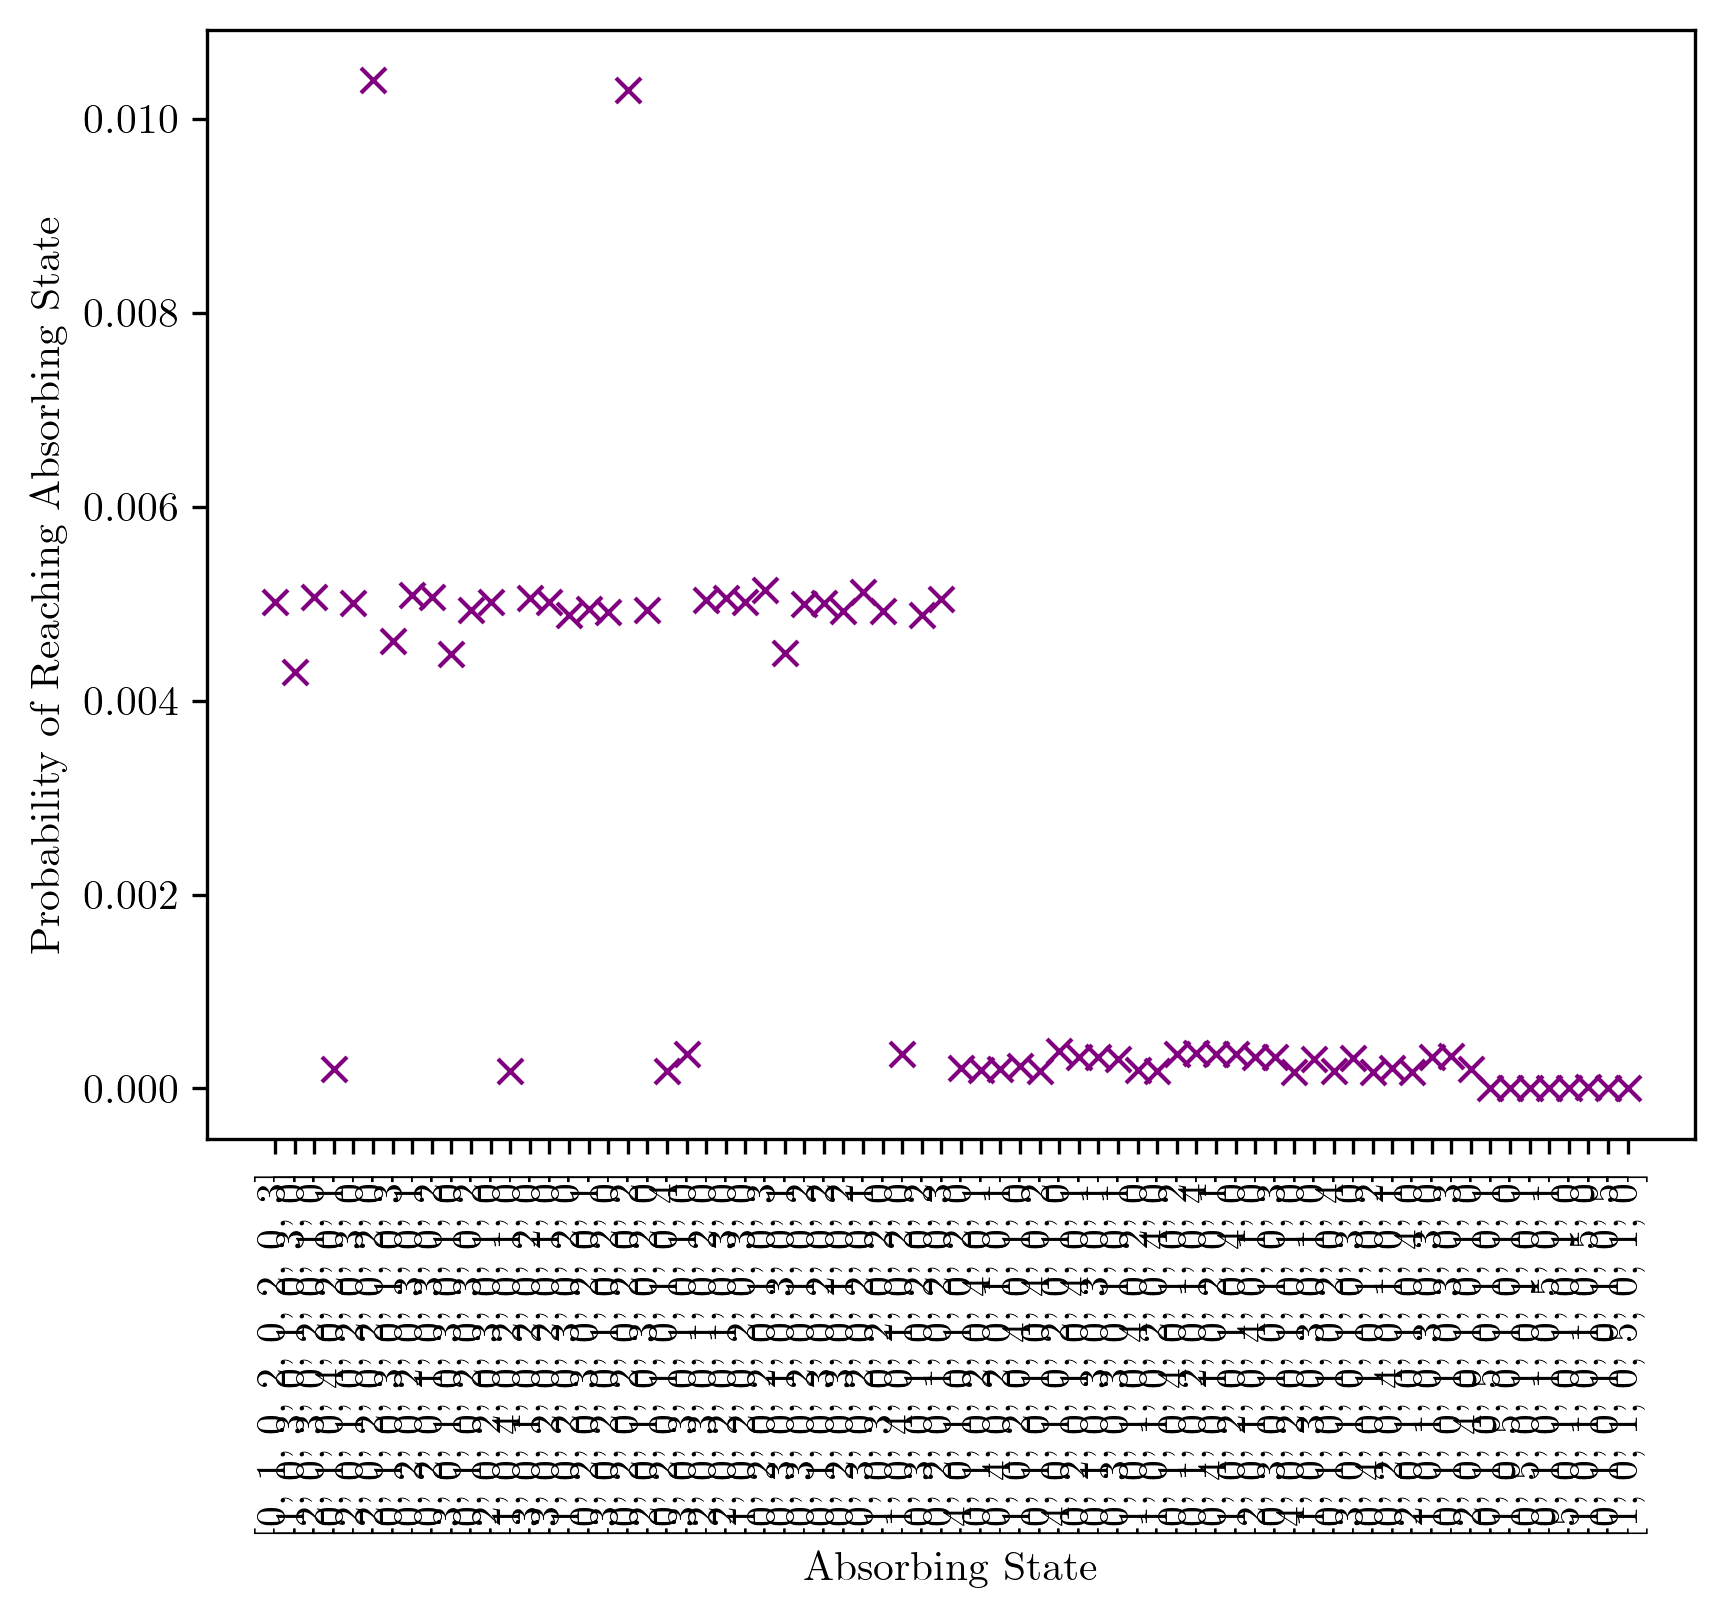

In [167]:
k = 4

Configurations = list(Data.get_probabilities_of_each_configuration(
    Data.get_data_of_k_occupied_sites(k)
).keys())
Probabilities = list(Data.get_probabilities_of_each_configuration(
    Data.get_data_of_k_occupied_sites(k)
).values())
plt.plot(Configurations, Probabilities, 'x', markersize=6, color='purple')
plt.xticks(rotation=90)
plt.xlabel("Absorbing State")
plt.ylabel("Probability of Reaching Absorbing State")
# plt.ylim(0, 0.06)

**Questions:**
1. What is the experimental probability of getting $N_s$ stacks at the end of the experiment?
2. Is the result that $\mathbb{P}(\{n_\ell\})\propto e^{-\beta N_s}$ true in the case that the rate is $e^{-\beta}$ instead of zero?
3. Is the above result true in the asymptotic limit $L\to\infty$? Numerically, we might try $L\approx 100$ or $L\approx 1000$.
4. Are there more clever ways of simulating this so that the long relaxation time constraint can be reduced? Maybe by making note of cycles and implicitly calculating for them?
5. Is the step-by-step evolution against a more continuous, asynchronous evolutionary process?
6. What is the form of the most likely configuration?

#### **Question 1**: $\mathbb{P}(N_s) =$ ?

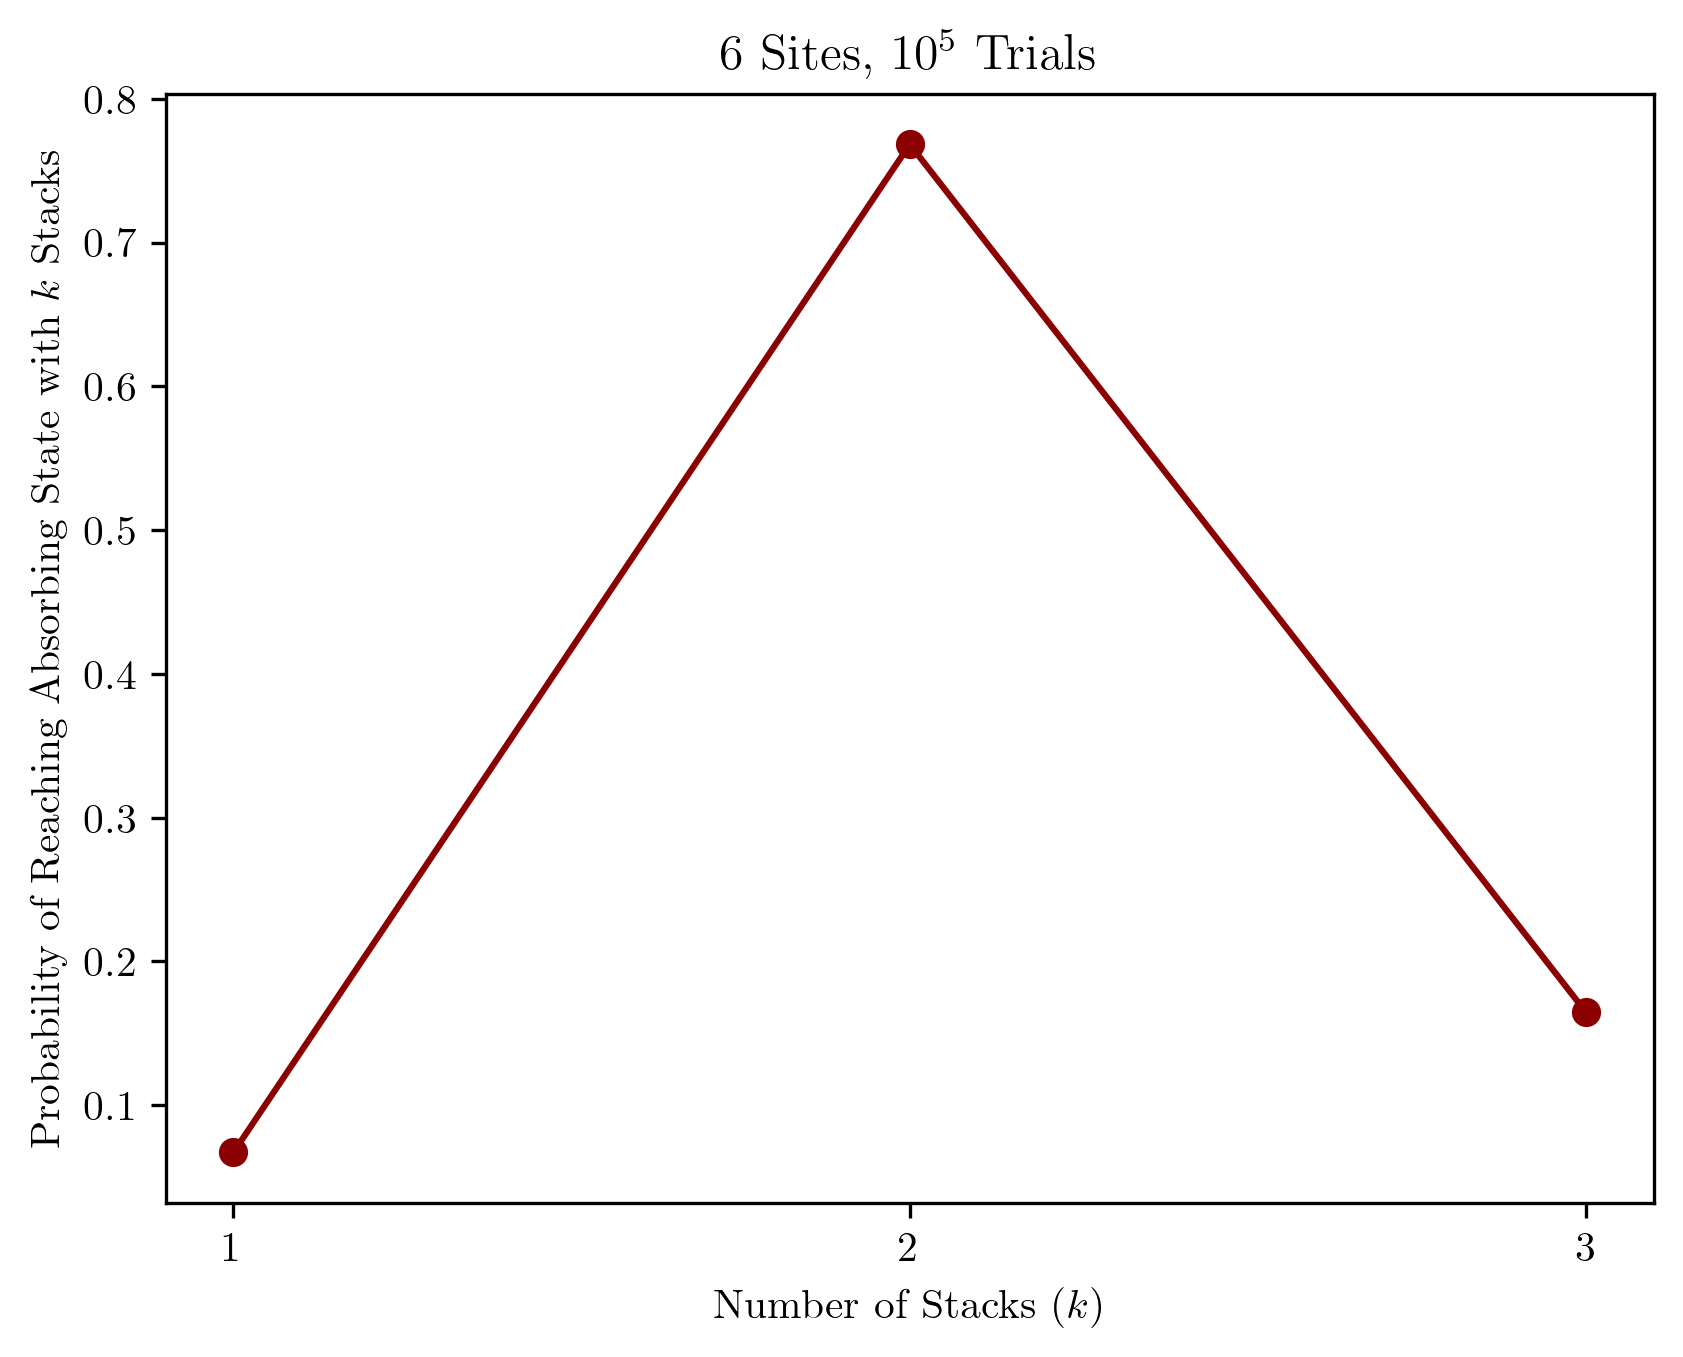

In [118]:
max_num_of_stacks = math.ceil(Sites / 2)
StackNumber = np.arange(1, max_num_of_stacks + 1)
Probabilities = [Data.get_probability_of_k_occupied_sites(k) for k in StackNumber]

plt.plot(StackNumber, Probabilities, 'o-', markersize=6, color='darkred')
plt.xlabel("Number of Stacks ($k$)")
plt.ylabel("Probability of Reaching Absorbing State with $k$ Stacks")
plt.title(f"{Sites} Sites, $10^{int(math.log10(Trials))}$ Trials")
plt.xticks(StackNumber)
None

#### **Question 6**: What is the form of the most likely absorbing state?

The following data is collected from experiments run with 100,000 trials
| $L$ sites | Most Probable Configuration | Probability |
| --------- | --------------------------- | ----------- |
| 4 | [4, 0, 0, 0] | 0.62519 |
| 5 | [0, 3, 0, 0, 2] | 0.55805 |
| 6 | [4, 0, 0, 2, 0, 0] | 0.19785 |
| 7 | [4, 0, 0, 0, 3, 0, 0] | 0.28128 |
| 8 | [0, 3, 0, 0, 2, 0, 3, 0] | 0.15735 |
| 9 | [3, 0, 0, 2, 0, 0, 4, 0, 0] | 0.08017 |
| 10 | [0, 0, 3, 0, 0, 4, 0, 0, 0, 3] | 0.07264 |
| 11 | [0, 3, 0, 0, 3, 0, 0, 2, 0, 3, 0] | 0.04469 |
| 12 | [4, 0, 0, 2, 0, 0, 3, 0, 0, 3, 0, 0] | 0.01925 |


Text(0, 0.5, 'Probability of Most Probable Absorbing State')

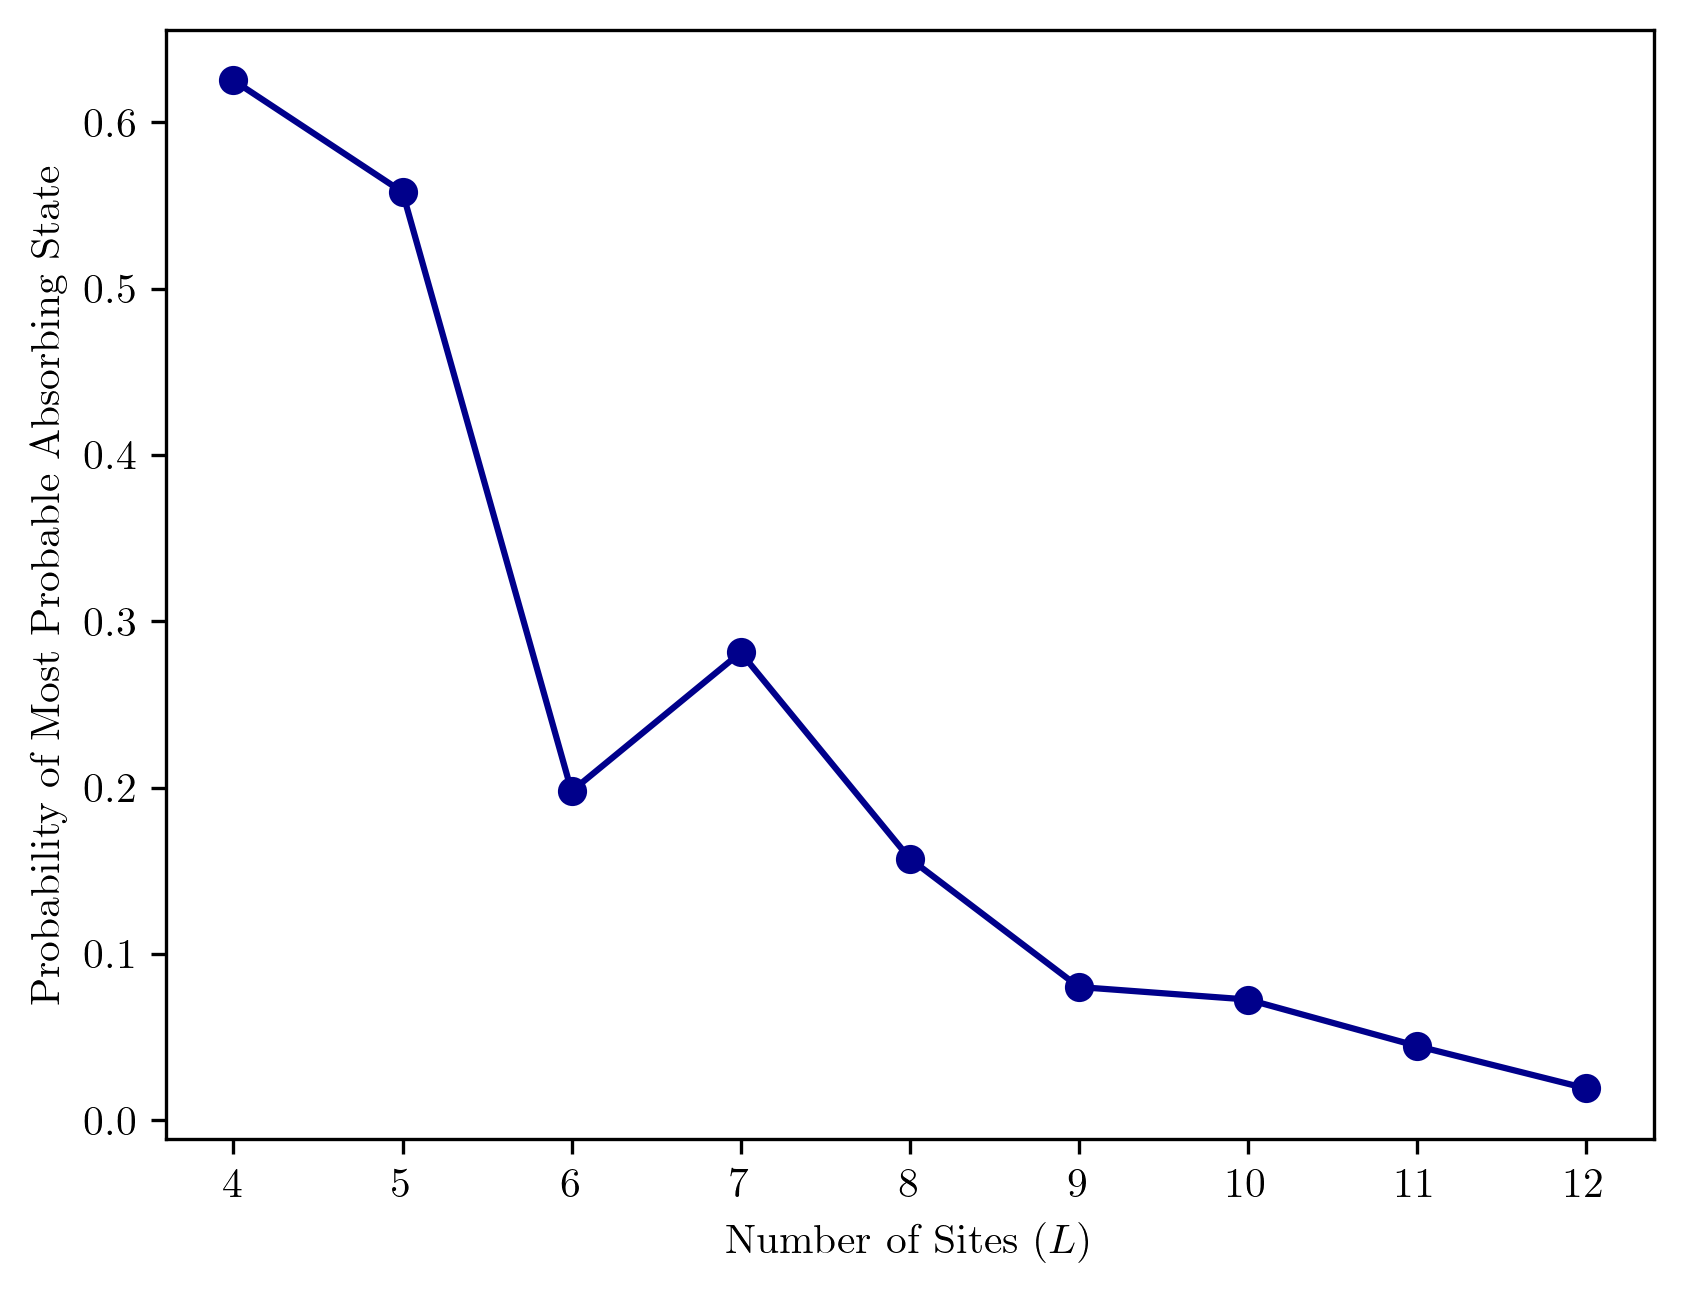

In [10]:
NumOfSites = np.arange(4, 12 + 1)
ProbabilityOfMostProbableAbsorbingState = [0.62519, 0.55805, 0.19785,0.28128, 0.15735, 0.08017, 0.07264, 0.04469, 0.01925]
plt.plot(NumOfSites, ProbabilityOfMostProbableAbsorbingState, 'o-', markersize=6, color='darkblue')
plt.xlabel("Number of Sites ($L$)")
plt.ylabel("Probability of Most Probable Absorbing State")

In [11]:
Data.get_most_probable_absorbing_state()

('[0, 4, 0, 0, 3, 0, 0, 3, 0, 0]', 0.0737)

### Notes

Maybe each (departure, arrival) interaction should have equal chance? Maybe that's what is meant by the target process theory. I might have to modify our rate function to account for this, since this might be accounting for the deviations in the problem. If this is the case, then this needs to be investigated very soon. In any case, all such concerns are related to the probabilitistic interpretation of the rate formalism. *Yes*, this was confirmed by Aanj.

### `TPConfiguration` Class

We will now switch focus to the case where $W_{k,\ell} = 0$ if $k=0$, equals $1$ if $k\neq 0, \ell\neq 0$, and equals $e^{-\beta}$ if $k\neq 0, \ell=0$. In this case, we should be able to reproduce the result that $$\mathbb{P}(\text{configuration})\propto e^{-\beta N_s}.$$ The primary idea will be to consider every single interaction and weigh its probability by the rate of that interaction, then randomly choose based on those weights. This might be the incorrect idea, but we'll see.

In [2]:
class TPConfiguration:
    ################################# INITIALIZATION #################################
    # initializes a configuration with a given number of sites and one particle per site
    def __init__(self, num_of_sites, beta=5):
        self.num_of_sites = num_of_sites
        self.data = [1] * num_of_sites
        self.beta = beta

    def from_string(self, config_string, beta=5):
        string_to_list = json.loads(config_string)
        self.num_of_sites = len(string_to_list)
        self.data = [int(x) for x in string_to_list]
        self.beta = beta
    
    ##################################### GETTERS #####################################
    # returns number of particles in the configuration (equal to number of sites, in default case)
    def get_num_of_particles(self):
        return sum(self.data)
    
    # returns number of empty sites in the configuration
    def get_num_of_empty_sites(self):
        return self.data.count(0)
    
    # returns number of occupied sites in the configuration, correlated sometimes with the number of "stacks"
    def get_num_of_occupied_sites(self):
        return self.num_of_sites - self.get_num_of_empty_sites()
    
    # returns a list of indices of empty sites
    def get_empty_sites(self):
        return [i for i, x in enumerate(self.data) if x == 0]
    
    # returns a list of indices of occupied sites
    def get_occupied_sites(self):
        return [i for i, x in enumerate(self.data) if x != 0]

    # returns a list of indices of occupied sites that have at least one neighbor occupied
    def get_occupied_sites_with_neighbors(self):
        return [
            i for i in self.get_occupied_sites() if
            (self.data[(i - 1) % self.num_of_sites] != 0 or self.data[(i + 1) % self.num_of_sites] != 0)
        ]
    
    def get_occupied_sites_with_k_occupied_neighbors(self, k):
        occupied_sites = self.get_occupied_sites()
        occupied_sites_with_k_neighbors = []
        for site in occupied_sites:
            left_neighbor = (site - 1) % self.num_of_sites
            right_neighbor = (site + 1) % self.num_of_sites
            neighbors = [left_neighbor, right_neighbor]
            occupied_neighbors = [n for n in neighbors if self.data[n] != 0]
            if len(occupied_neighbors) == k:
                occupied_sites_with_k_neighbors.append(site)
        return occupied_sites_with_k_neighbors
    
    # returns a list of occupied neighbors of a given site index
    def get_occupied_neighbors(self, index):
        left_neighbor = (index - 1) % self.num_of_sites
        right_neighbor = (index + 1) % self.num_of_sites
        return [
            i for i in [left_neighbor, right_neighbor] if self.data[i] != 0
        ]
        
    # returns a list of all possible pairs of departure and arrival sites, i.e., those pairs where the first index is an occupied site
    # and the second index is one of the neighbors of the first index (occupied or empty). this is different from the original method,
    # as it includes empty neighbors as well, and we save the weight of each pair, as well
    def get_all_departure_arrival_pairs(self):
        pairs = []
        weights = []
        for departure_index in self.get_occupied_sites():
            left_neighbor = (departure_index - 1) % self.num_of_sites
            right_neighbor = (departure_index + 1) % self.num_of_sites
            for arrival_index in [left_neighbor, right_neighbor]:
                if self.data[arrival_index] != 0:
                    weight = 1.00
                    pairs.append((departure_index, arrival_index))
                    weights.append(weight)
                else:
                    weight = np.exp(-self.beta)
                    pairs.append((departure_index, arrival_index))
                    weights.append(weight)
        return pairs, weights
    
    # functions that provide statistical measures of the system as a measure for steady-state behavior
    def probability_of_k_particles_at_a_site(self, k):
        number_of_sites_with_k_particles = 0
        for site in self.data:
            if site == k:
                number_of_sites_with_k_particles += 1
        return number_of_sites_with_k_particles / len(self.data)

    ##################################### SELECTORS #####################################
    # selects a random index of an occupied site
    def select_random_occupied_site(self):
        occupied_indices = self.get_occupied_sites()
        if occupied_indices:
            return random.choice(occupied_indices)
        else:
            raise ValueError("No occupied sites available to select from.")
    
    # selects a random index of an occupied site, with the constraint that at least one neighbor must be occupied
    # i.e., the selected site must have at least one neighbor that is occupied. this will be the departure site.
    def select_random_occupied_site_with_neighbor(self):
        occupied_indices = self.get_occupied_sites()
        if len(occupied_indices) == 0:
            raise ValueError("No occupied sites available to select from.")
        
        occupied_indices_with_neighbors = self.get_occupied_sites_with_neighbors()
        if len(occupied_indices_with_neighbors) == 0:
            return -1   # represents that the process cannot continue, as no occupied site has a neighbor
                        # i.e, we have reached an absorbing state
        else:
            return random.choice(occupied_indices_with_neighbors)

    # selects a pair of departure and arrival sites, i.e., a pair of indices such that the first index is an occupied site
    # and the second index is one of the neighbors of the first index (occupied or empty). the choice is made with respect
    # to the weights of the pairs, i.e., the probability of selecting a pair is proportional to its weight
    def select_departure_and_arrival_sites(self):
        pairs, weights = self.get_all_departure_arrival_pairs()
        if not pairs:
            return -1, -1
        weights = np.array(weights)
        weights /= np.sum(weights)
        selected_pair_index = np.random.choice(len(pairs), p=weights)
        departure_index, arrival_index = pairs[selected_pair_index]
        return departure_index, arrival_index
    
    ##################################### EVOLVERS #####################################
    # evolves the configuration by moving a particle from a departure site to an arrival site
    def evolve(self):
        # # select departure site type: there are three types, those with no occupied neighbors, ..., those with two occupied neighbors
        num_of_occupied_sites_with_no_occupied_neighbors = len(self.get_occupied_sites_with_k_occupied_neighbors(0))
        num_of_occupied_sites_with_one_occupied_neighbor = len(self.get_occupied_sites_with_k_occupied_neighbors(1))
        num_of_occupied_sites_with_two_occupied_neighbors = len(self.get_occupied_sites_with_k_occupied_neighbors(2))
        A = num_of_occupied_sites_with_no_occupied_neighbors * 2.0 * np.exp(-self.beta)
        B = num_of_occupied_sites_with_one_occupied_neighbor * (np.exp(-self.beta) + 1)
        C = num_of_occupied_sites_with_two_occupied_neighbors * 2.0
        total_weight = A + B + C
        
        departure_type = np.random.choice(
            ['A', 'B', 'C'],
            p=[A / total_weight, B / total_weight, C / total_weight]
        )

        departure_index = -1
        if departure_type == 'A':
            departure_index = random.choice(self.get_occupied_sites_with_k_occupied_neighbors(0))
        elif departure_type == 'B':
            departure_index = random.choice(self.get_occupied_sites_with_k_occupied_neighbors(1))
        elif departure_type == 'C':
            departure_index = random.choice(self.get_occupied_sites_with_k_occupied_neighbors(2))
        else:
            raise ValueError("Invalid departure type selected.")
        
        # move the particle from departure to arrival
        left_neighbor = (departure_index - 1) % self.num_of_sites
        right_neighbor = (departure_index + 1) % self.num_of_sites
        weights_of_neighbors = []
        for neighbor in [left_neighbor, right_neighbor]:
            if self.data[neighbor] != 0:
                weights_of_neighbors.append(1.00)
            else:
                weights_of_neighbors.append(np.exp(-self.beta))
        weights_of_neighbors = np.array(weights_of_neighbors)
        weights_of_neighbors /= np.sum(weights_of_neighbors)  # normalize the weights
        selected_neighbor_index = np.random.choice([left_neighbor, right_neighbor], p=weights_of_neighbors)
        self.data[departure_index] -= 1
        self.data[selected_neighbor_index] += 1
        return True
        # departure_index, arrival_index = self.select_departure_and_arrival_sites()
        # if departure_index == -1:
        #     return False
        # # move the particle from departure to arrival
        # self.data[departure_index] -= 1
        # self.data[arrival_index] += 1
        # return True
    
    # evolves for a certain amount of time steps, since absorbing states cannot be reached in this process
    def evolve_for_time_steps(self, time_steps):
        for _ in range(time_steps):
            if not self.evolve():
                raise ValueError("The process cannot continue, as no occupied site has a neighbor.")
                break

            # check if we have reached an absorbing state, an additional constraint
            if self.get_occupied_sites_with_neighbors() == 0:
                break
        return time_steps, self.data

    ##################################### CHECKERS #####################################
    # the purpose of this section of methods is to check if two different configurations are equal,
    # up to rotational and reflectional symmetry (i.e., under the action of the dihedral group D_2n)
    def is_equal_to(self, other):
        # if self.num_of_sites != other.num_of_sites:
        #     return False
        
        # for _ in range(self.num_of_sites):
        #     if self.data == other.data:
        #         return True
        #     # rotate the other configuration
        #     other.data = other.data[1:] + other.data[:1]
        
        # # check reflection
        # reflected_other = other.data[::-1]
        # for _ in range(self.num_of_sites):
        #     if self.data == reflected_other:
        #         return True
        #     # rotate the reflected configuration
        #     reflected_other = reflected_other[1:] + reflected_other[:1]

        # naive approach to check equality ignoring symmetry
        if self.data == other.data:
            return True
        
        return False
        

In [3]:
L = 500
config = TPConfiguration(L, beta=100)
ProbabilitySeries = [
    [1]
]
for _ in range(L-1):
    ProbabilitySeries.append([0])
NumberOfStacks = [L]
Time = 100_000

for _ in tqdm(range(Time)):
    config.evolve()
    for k in range(1, L + 1):
        prob_of_k_particles = config.probability_of_k_particles_at_a_site(k)
        ProbabilitySeries[k - 1].append(prob_of_k_particles)
    NumberOfStacks.append(config.get_num_of_occupied_sites())


100%|██████████| 100000/100000 [07:49<00:00, 212.82it/s]


In [5]:
lst = [0,1,2,3,4,5, 6, 7]
colors = plt.cm.viridis(np.linspace(0, 1, len(lst)))
howMany = None

In [ ]:
TimeSeries = list(range(Time + 1))
for k in lst:
    if howMany is None:
        plt.plot(TimeSeries, ProbabilitySeries[k], label=f"Probability of ${k+1}$ particles", color=colors[(len(lst)-1)-k % len(lst)], linewidth=1)
    else:
        plt.plot(TimeSeries[-howMany:], ProbabilitySeries[k][-howMany:], label=f"Probability of ${k}$ particles", color=colors[(len(lst)-1)-k % len(lst)], linewidth=1)
plt.legend()
plt.show()

13

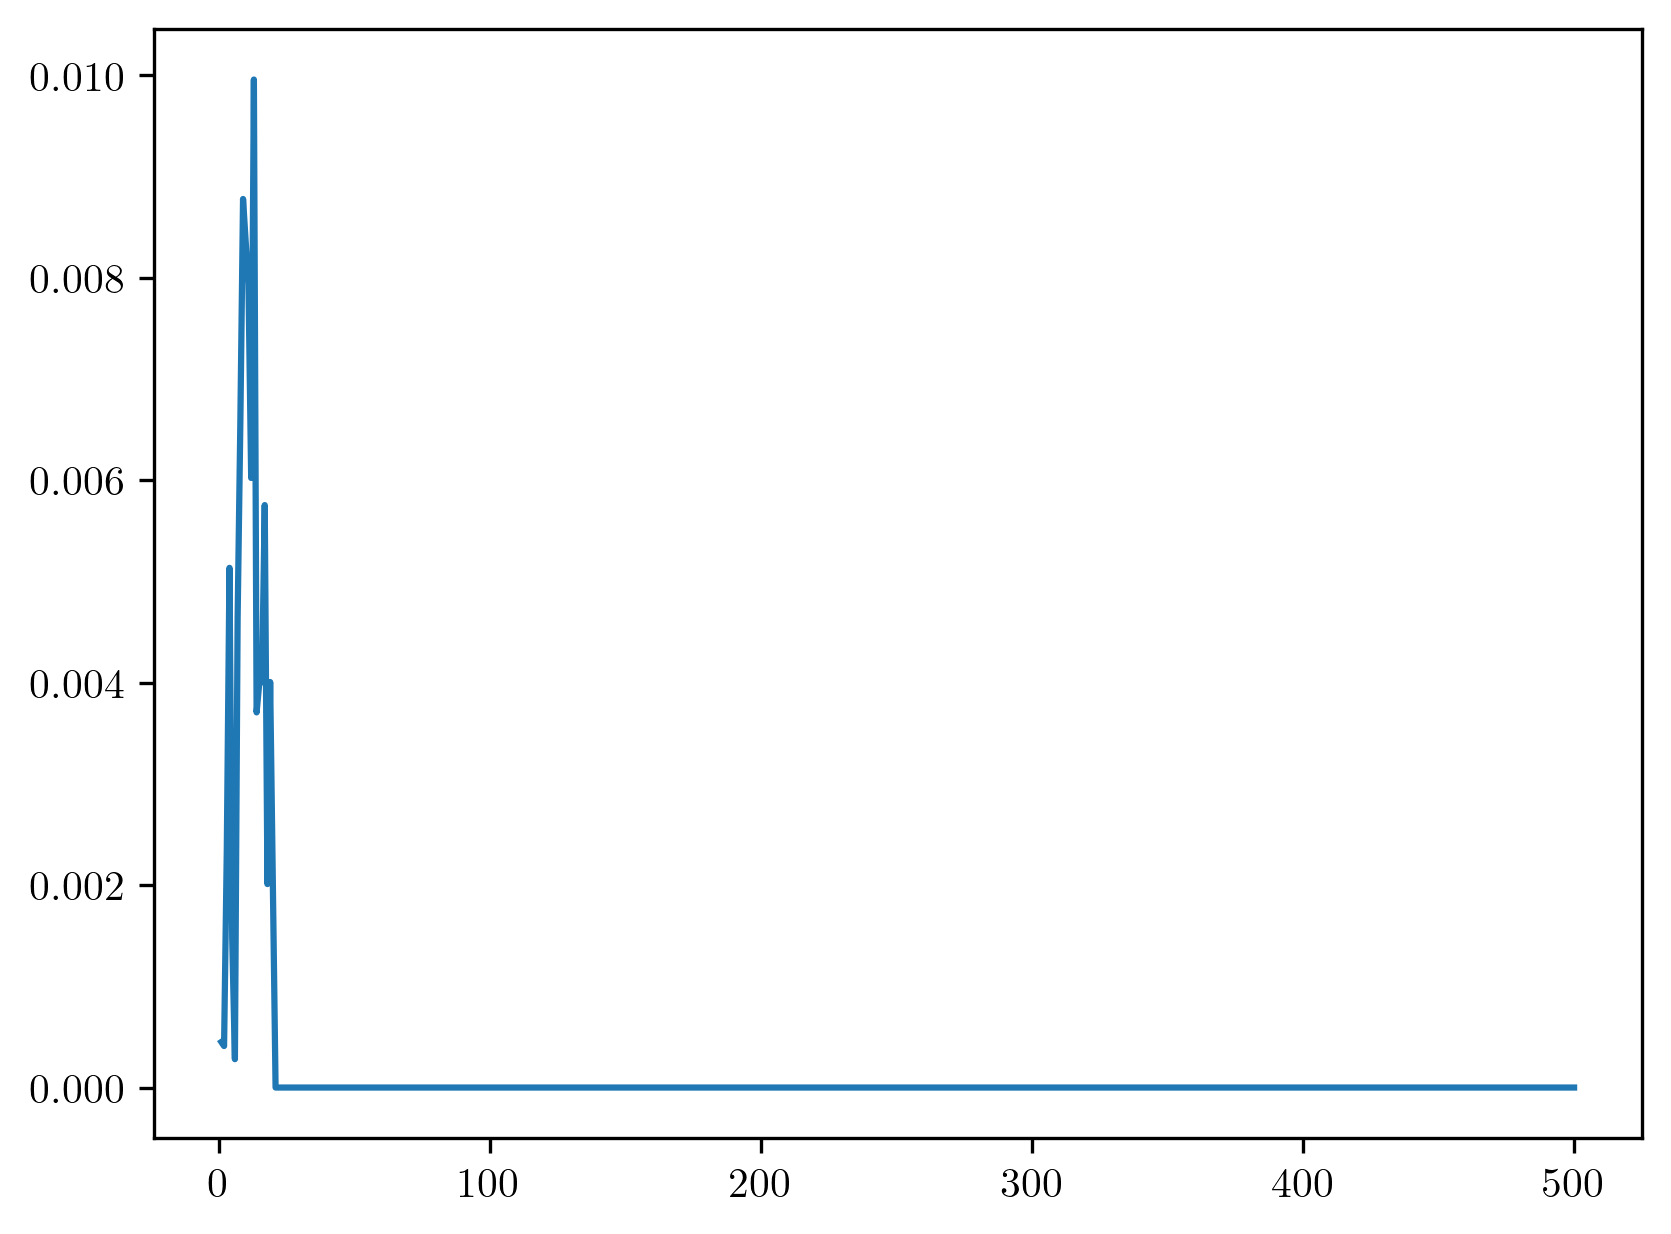

In [1088]:
AverageStationaryProbability = [
    np.mean(series[-1000:]) for series in ProbabilitySeries
]

plt.plot(list(range(1, len(ProbabilitySeries) + 1)), AverageStationaryProbability)
AverageStationaryProbability.index(max(AverageStationaryProbability)) + 1

/var/folders/ch/323vjlg56bn6ntp51c02pyg80000gn/T/ipykernel_45007/1844397532.py:6: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


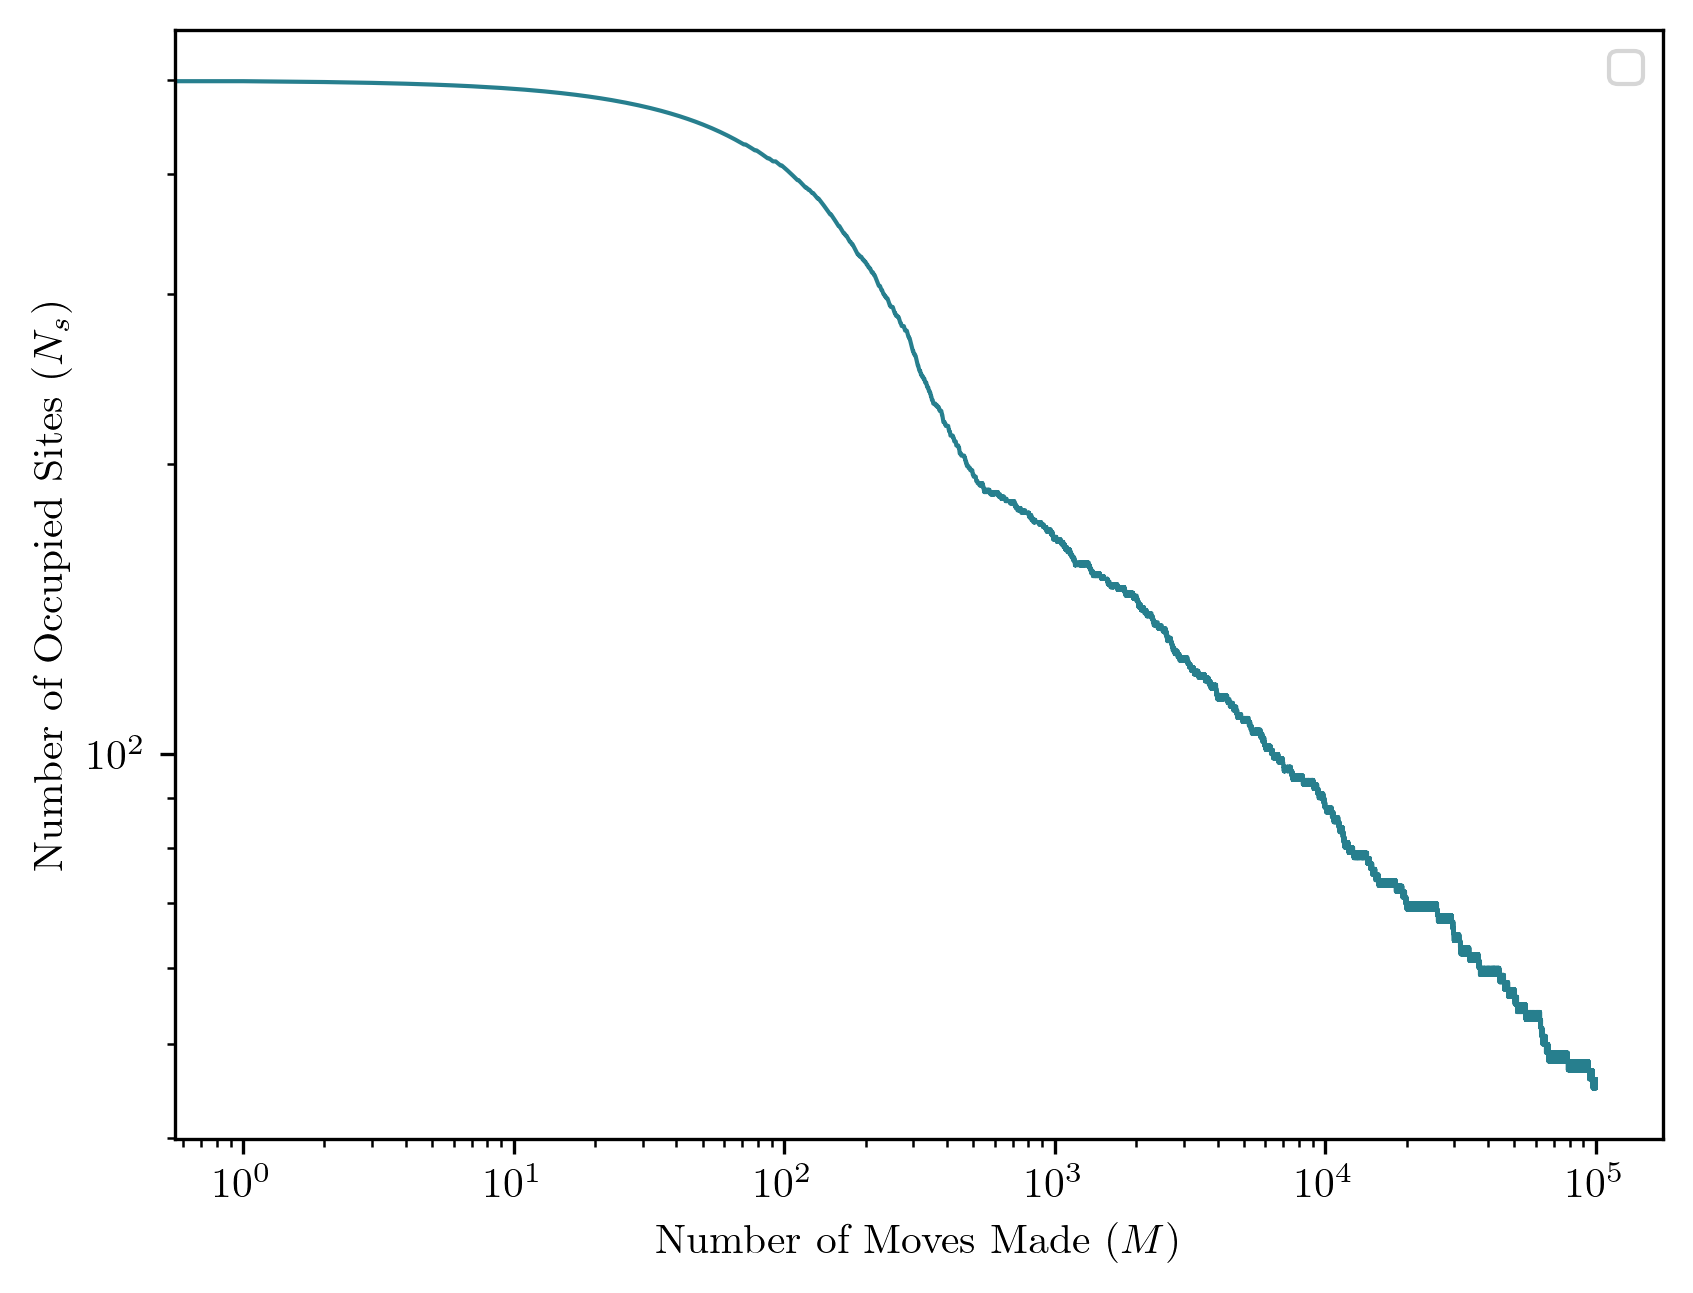

In [7]:
TimeSeries = np.array(list(range(Time + 1)))
plt.plot(TimeSeries, NumberOfStacks, color=colors[3], linewidth=1)
# plt.plot(TimeSeries, 500*np.exp(-0.001*TimeSeries), color=colors[5], linewidth=1)
plt.yscale('log')
plt.xscale('log')
plt.legend()
plt.xlabel("Number of Moves Made ($M$)")
plt.ylabel("Number of Occupied Sites ($N_s$)")
plt.show()

In [414]:
class ManyTPConfigurationExperiment:
    def __init__(self, num_of_sites, beta=5, time_steps=1000):
        self.num_of_sites = num_of_sites
        self.beta = beta
        self.time_steps = time_steps
        self.data = {                                           # dictionary to store configurations and their counts, 
                                                # where keys are configurations as strings and values are an array of time steps to reach absorbing state
            str([num_of_sites] + [0]*(num_of_sites - 1)): []    # initial configuration with all particles at the first site
        }
    
    def run_trial(self):
        config = TPConfiguration(self.num_of_sites, beta=self.beta)
        time_steps, data = config.evolve_for_time_steps(self.time_steps)

        configuration_already_exists = False
        for key in self.data.keys():
            existing_config = TPConfiguration(self.num_of_sites, beta=self.beta)
            existing_config.from_string(key)
            if existing_config.is_equal_to(config):
                self.data[key].append(time_steps)
                configuration_already_exists = True
                break
        
        if not configuration_already_exists:
            self.data[str(config.data)] = [time_steps]
    
    def run_trials(self, num_of_trials):
        for _ in tqdm(range(num_of_trials)):
            self.run_trial()
    
    def get_data_of_k_occupied_sites(self, k):
        new_data = {}
        for key, time_steps in self.data.items():
            config = TPConfiguration(self.num_of_sites)
            config.from_string(key)
            if config.get_num_of_occupied_sites() == k:
                new_data[key] = time_steps
        return new_data

    def get_num_of_trials(self):
        return sum(len(time_steps) for time_steps in self.data.values())
    
    def get_number_of_events_in_each_configuration(self, map=None):
        if map is None:
            map = {key: len(value) for key, value in self.data.items()}
        else:
            map = {key: len(value) for key, value in map.items()}
        return map

    def get_probabilities_of_each_configuration(self, map=None):
        if map is None:
            map = {key: len(value)/self.get_num_of_trials() for key, value in self.data.items()}
        else:
            map = {key: len(value)/self.get_num_of_trials() for key, value in map.items()}
        return map
    
    def get_number_of_absorbing_states(self):
        return len(self.data)
    
    def get_probability_of_k_occupied_sites(self, k):
        total_trials = self.get_num_of_trials()
        if total_trials == 0:
            return 0
        k_data = self.get_data_of_k_occupied_sites(k)
        k_trials = sum(len(time_steps) for time_steps in k_data.values())
        return k_trials / total_trials if k_trials > 0 else 0
    
    def get_most_probable_absorbing_state(self):
        probabilities = self.get_probabilities_of_each_configuration()
        most_probable_state = max(probabilities, key=probabilities.get)
        return most_probable_state, probabilities[most_probable_state]

In [366]:
Config = TPConfiguration(10, beta=5)
Config.from_string("[4, 0, 1, 0, 5, 0]", beta=5)
for _ in range(20):
    Config.evolve_for_time_steps(1)
    print(Config.data)

[4, 0, 1, 1, 4, 0]
[4, 0, 0, 2, 4, 0]
[4, 0, 0, 3, 3, 0]
[4, 0, 0, 4, 2, 0]
[4, 0, 0, 3, 3, 0]
[4, 0, 0, 2, 4, 0]
[4, 0, 0, 3, 3, 0]
[4, 0, 0, 4, 2, 0]
[4, 0, 0, 3, 3, 0]
[4, 0, 0, 4, 2, 0]
[4, 0, 0, 3, 3, 0]
[4, 0, 0, 2, 4, 0]
[4, 0, 0, 1, 5, 0]
[4, 0, 0, 0, 6, 0]
[3, 0, 0, 0, 6, 1]
[2, 0, 0, 0, 6, 2]
[3, 0, 0, 0, 6, 1]
[3, 0, 0, 0, 7, 0]
[3, 0, 0, 1, 6, 0]
[3, 0, 0, 2, 5, 0]


In [765]:
sites = 6                            # number of sites
trials = 10_000                     # number of trials to run
time_steps = 100
beta = 0
experiment = ManyTPConfigurationExperiment(sites, beta=beta, time_steps=time_steps)
experiment.run_trials(trials)

100%|██████████| 10000/10000 [00:16<00:00, 609.01it/s]


In [767]:
experiment.get_probabilities_of_each_configuration(
    experiment.get_data_of_k_occupied_sites(3)
)

{'[3, 1, 0, 2, 0, 0]': 0.0032,
 '[0, 2, 0, 1, 3, 0]': 0.0036,
 '[2, 0, 1, 0, 0, 3]': 0.0036,
 '[0, 0, 0, 2, 3, 1]': 0.0038,
 '[4, 0, 0, 1, 1, 0]': 0.0047,
 '[0, 0, 0, 2, 1, 3]': 0.0053,
 '[2, 3, 0, 0, 1, 0]': 0.0031,
 '[3, 1, 0, 0, 0, 2]': 0.0041,
 '[3, 1, 0, 0, 2, 0]': 0.0031,
 '[1, 2, 0, 0, 0, 3]': 0.0033,
 '[1, 1, 0, 4, 0, 0]': 0.0041,
 '[1, 0, 0, 4, 0, 1]': 0.0037,
 '[0, 3, 1, 2, 0, 0]': 0.0032,
 '[1, 1, 0, 0, 4, 0]': 0.0042,
 '[1, 0, 0, 3, 0, 2]': 0.004,
 '[0, 0, 0, 1, 1, 4]': 0.0029,
 '[0, 0, 1, 3, 2, 0]': 0.0042,
 '[2, 0, 0, 0, 3, 1]': 0.0048,
 '[0, 1, 0, 2, 3, 0]': 0.0036,
 '[1, 0, 0, 1, 4, 0]': 0.0042,
 '[1, 3, 2, 0, 0, 0]': 0.0046,
 '[0, 0, 1, 0, 2, 3]': 0.0042,
 '[4, 0, 1, 0, 0, 1]': 0.0043,
 '[2, 0, 1, 3, 0, 0]': 0.0038,
 '[0, 2, 3, 1, 0, 0]': 0.0038,
 '[2, 0, 0, 0, 1, 3]': 0.0036,
 '[3, 1, 2, 0, 0, 0]': 0.0044,
 '[0, 0, 3, 0, 2, 1]': 0.004,
 '[1, 0, 0, 3, 2, 0]': 0.0045,
 '[0, 4, 0, 1, 1, 0]': 0.0041,
 '[0, 0, 4, 1, 1, 0]': 0.0045,
 '[0, 0, 2, 0, 1, 3]': 0.0057,
 '[3, 0, 0

In [480]:
KSeries = [1, 2, 3, 4, 5, 6, 7, 8]
Probabilities = [experiment.get_probability_of_k_occupied_sites(k) for k in KSeries]

Text(0, 0.5, 'Probability of Reaching Absorbing State with $k$ Stacks')

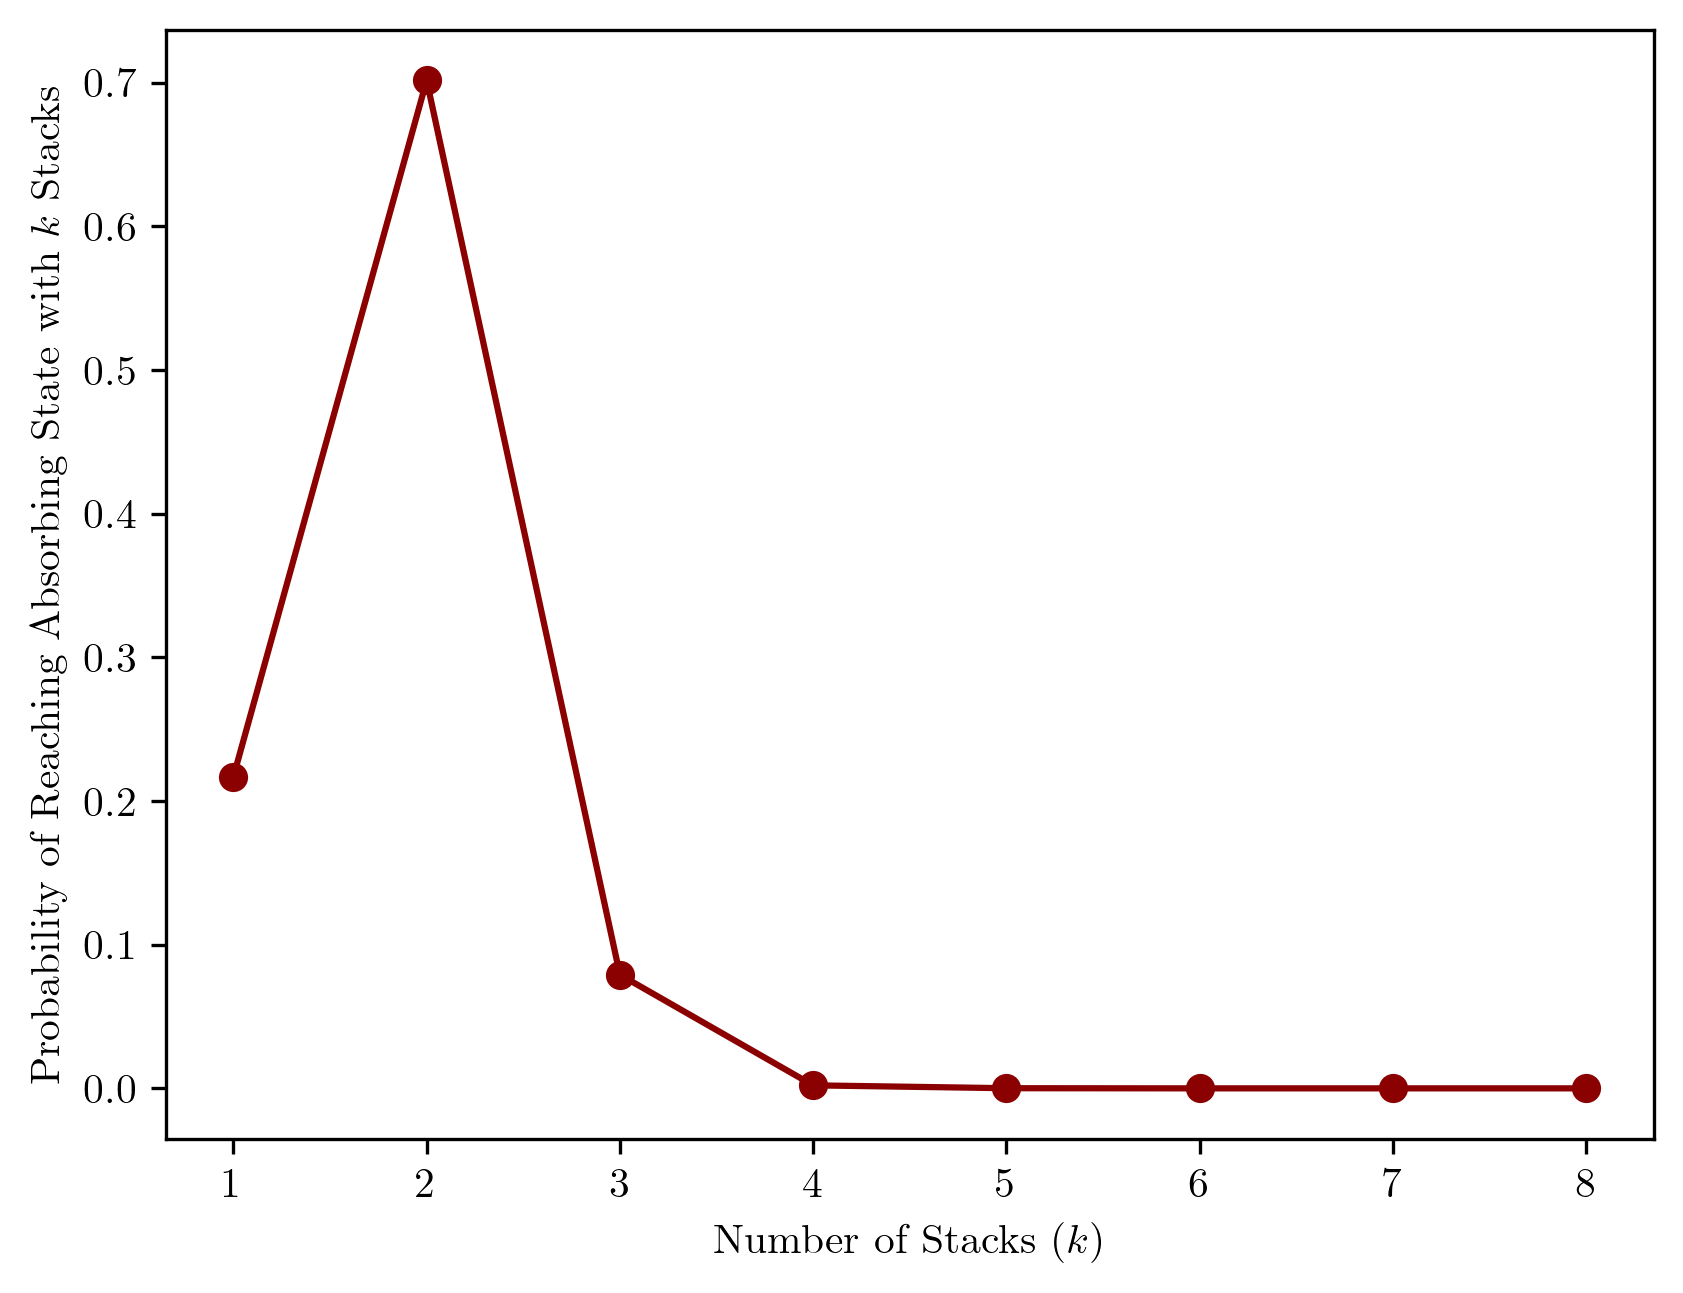

In [481]:
plt.plot(KSeries, Probabilities, 'o-', markersize=6, color='darkred')
# plt.yscale('log')

plt.xlabel("Number of Stacks ($k$)")
plt.ylabel("Probability of Reaching Absorbing State with $k$ Stacks")

In [390]:
k = 3

Configurations = list(experiment.get_probabilities_of_each_configuration(
    experiment.get_data_of_k_occupied_sites(k)
).keys())
Probabilities = list(experiment.get_probabilities_of_each_configuration(
    experiment.get_data_of_k_occupied_sites(k)
).values())
plt.plot(Configurations, Probabilities, 'x', markersize=6, color='purple')
plt.xticks(rotation=90)
plt.xlabel("Final State")
plt.ylabel("Probability of Reaching Final State")
# plt.ylim(0, 0.06)

Text(0, 0.5, 'Probability of Reaching Final State')

Error in callback <function _draw_all_if_interactive at 0x11f0d6ac0> (for post_execute), with arguments args (),kwargs {}:


KeyboardInterrupt: 

Error in callback <function flush_figures at 0x11f137ce0> (for post_execute), with arguments args (),kwargs {}:


KeyboardInterrupt: 

Max Prob. of # of Stacks: 1


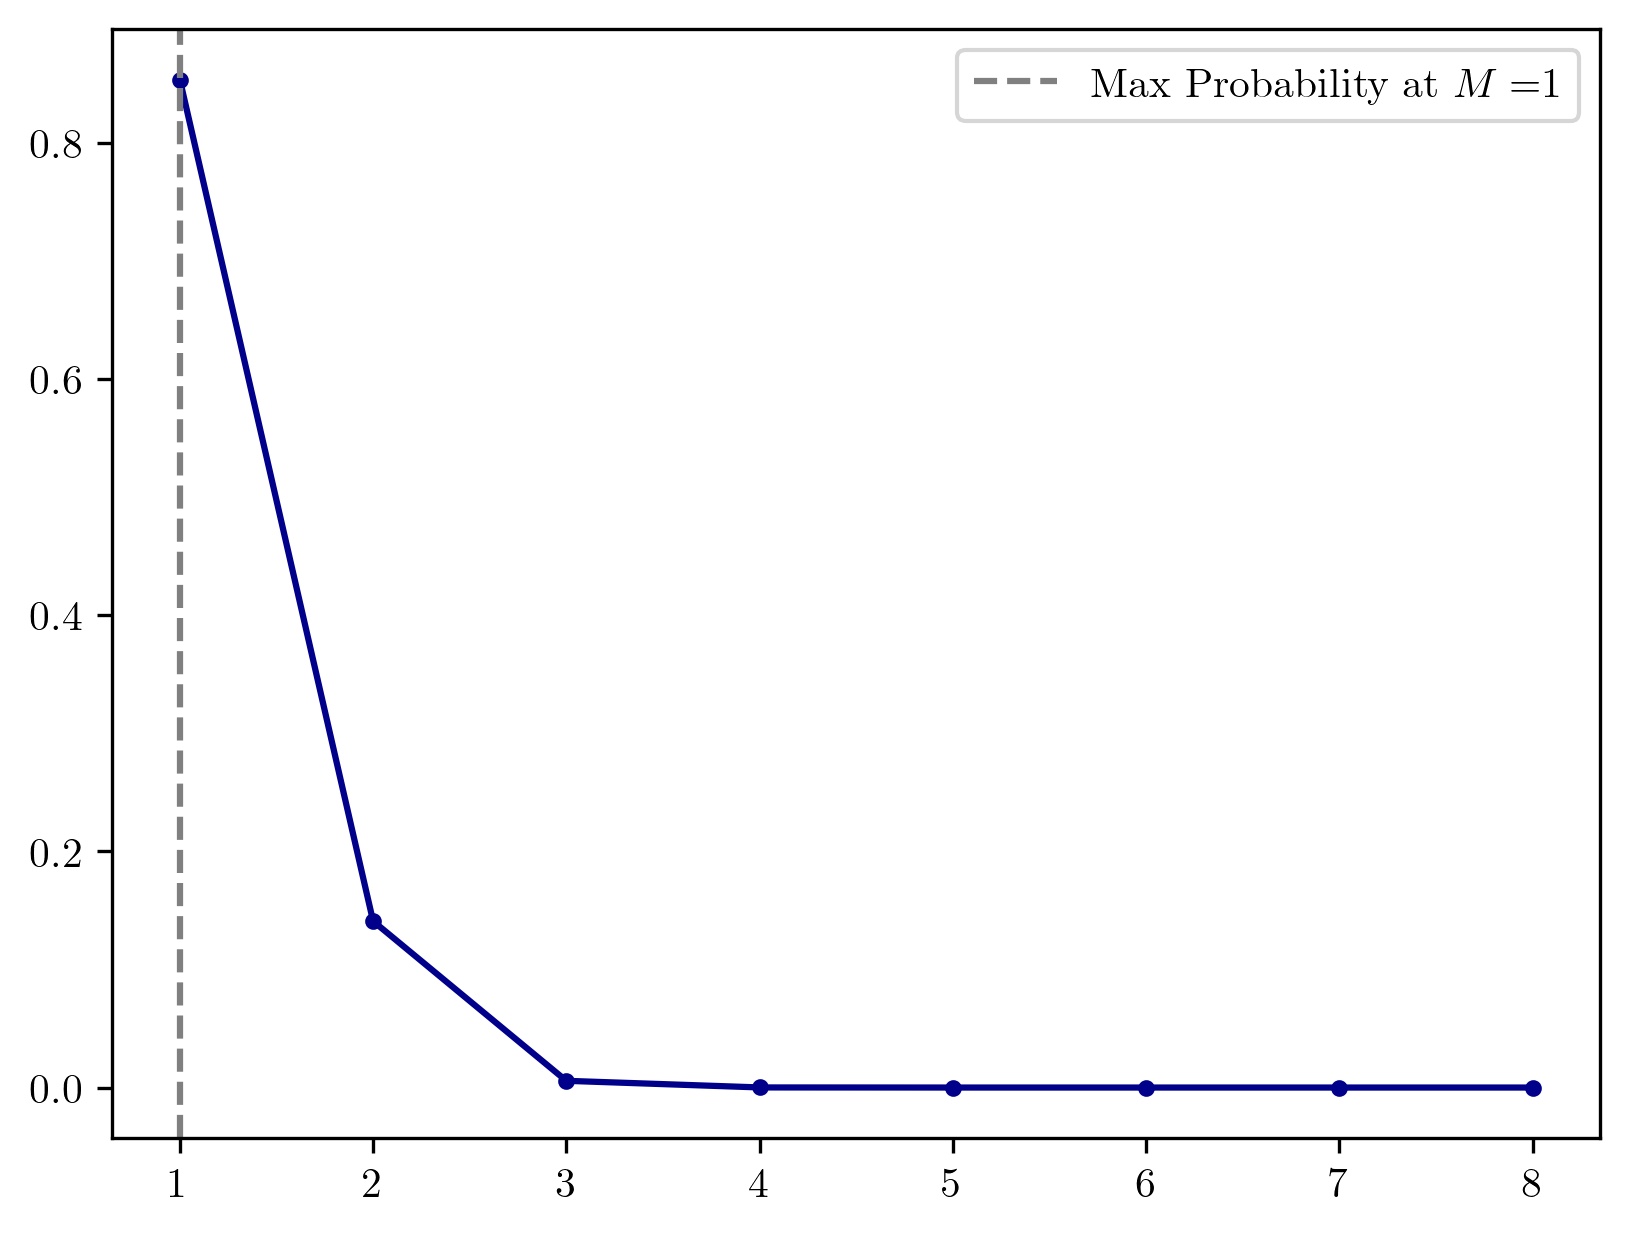

In [764]:
beta = 5
L = 8
prob_of_M_occupied_sites = []
for M in range(1, L + 1):
    prob = comb(L, M)*comb(L-1, M-1) * np.exp(-beta * M)
    prob_of_M_occupied_sites.append(prob)

prob_of_M_occupied_sites = np.array(prob_of_M_occupied_sites)
prob_of_M_occupied_sites /= np.sum(prob_of_M_occupied_sites)  # normalize the probabilities
plt.plot(range(1, L + 1), prob_of_M_occupied_sites, 'o-', markersize=3, color='darkblue')
# plt.yscale('log')

# plot max value as a vertica line
max_index = np.argmax(prob_of_M_occupied_sites)
plt.axvline(x=max_index + 1, color='gray', linestyle='--', label='Max Probability at $M = $' + str(max_index + 1))
plt.legend()
print('Max Prob. of # of Stacks:', max_index + 1)
# plt.yscale('log')

### Simplified Simulation of Target Processes

In [484]:
# checking if two configurations are equal
def check_if_equal(config1, config2):
    return config1 == config2

In [754]:
beta = 5
L = 6
system = [1]*L
time = 0

# rate functions
def v(l):
    return np.exp(-beta) if l == 0 else 1.0

def rate(sys, departure_site, arrival_site):
    if sys[departure_site] == 0:
        return 0.0
    elif arrival_site == (departure_site - 1) % len(sys) or arrival_site == (departure_site + 1) % len(sys):
        return v(sys[arrival_site])
    else:
        return 0.0

In [755]:
def occupied_sites(sys):
    return [i for i, x in enumerate(sys) if x != 0]

def departure_arrival_pairs(sys):
    pairs = []
    weights = []
    for departure_index in occupied_sites(sys):
        left_neighbor = (departure_index - 1) % len(sys)
        right_neighbor = (departure_index + 1) % len(sys)
        for arrival_index in [left_neighbor, right_neighbor]:
            weight = -1
            if sys[arrival_index] != 0:
                weight = 1.0
            else:
                weight = np.exp(-beta)
            pairs.append((departure_index, arrival_index))
            weights.append(weight)
    probabilities = np.array(weights)
    Delta_T = np.sum(probabilities)
    probabilities /= np.sum(probabilities)
    return pairs, probabilities, Delta_T

def select_departure_arrival_pair(sys):
    pairs, probabilities, Delta_T = departure_arrival_pairs(sys)
    if not pairs:
        return -1, -1
    selected_pair_index = np.random.choice(len(pairs), p=probabilities)
    return pairs[selected_pair_index], Delta_T

def move_particle(sys):
    global time
    (departure_index, arrival_index), Delta_T = select_departure_arrival_pair(sys)
    if departure_index == -1:
        return False  # cannot move, no valid pair found
    sys[departure_index] -= 1
    sys[arrival_index] += 1
    time += Delta_T
    return sys

In [756]:
trials = 10_000
data = []

for _ in tqdm(range(trials)):
    system = [1]*L
    time = 0
    while time < 1000:
        move_particle(system)
    data.append((system.copy(), time))


100%|██████████| 10000/10000 [01:22<00:00, 120.55it/s]


In [757]:
reduced_data = {}
for config, t in data:
    config_str = str(config)
    if config_str not in reduced_data:
        reduced_data[config_str] = 0
    reduced_data[config_str] += 1

([], [])

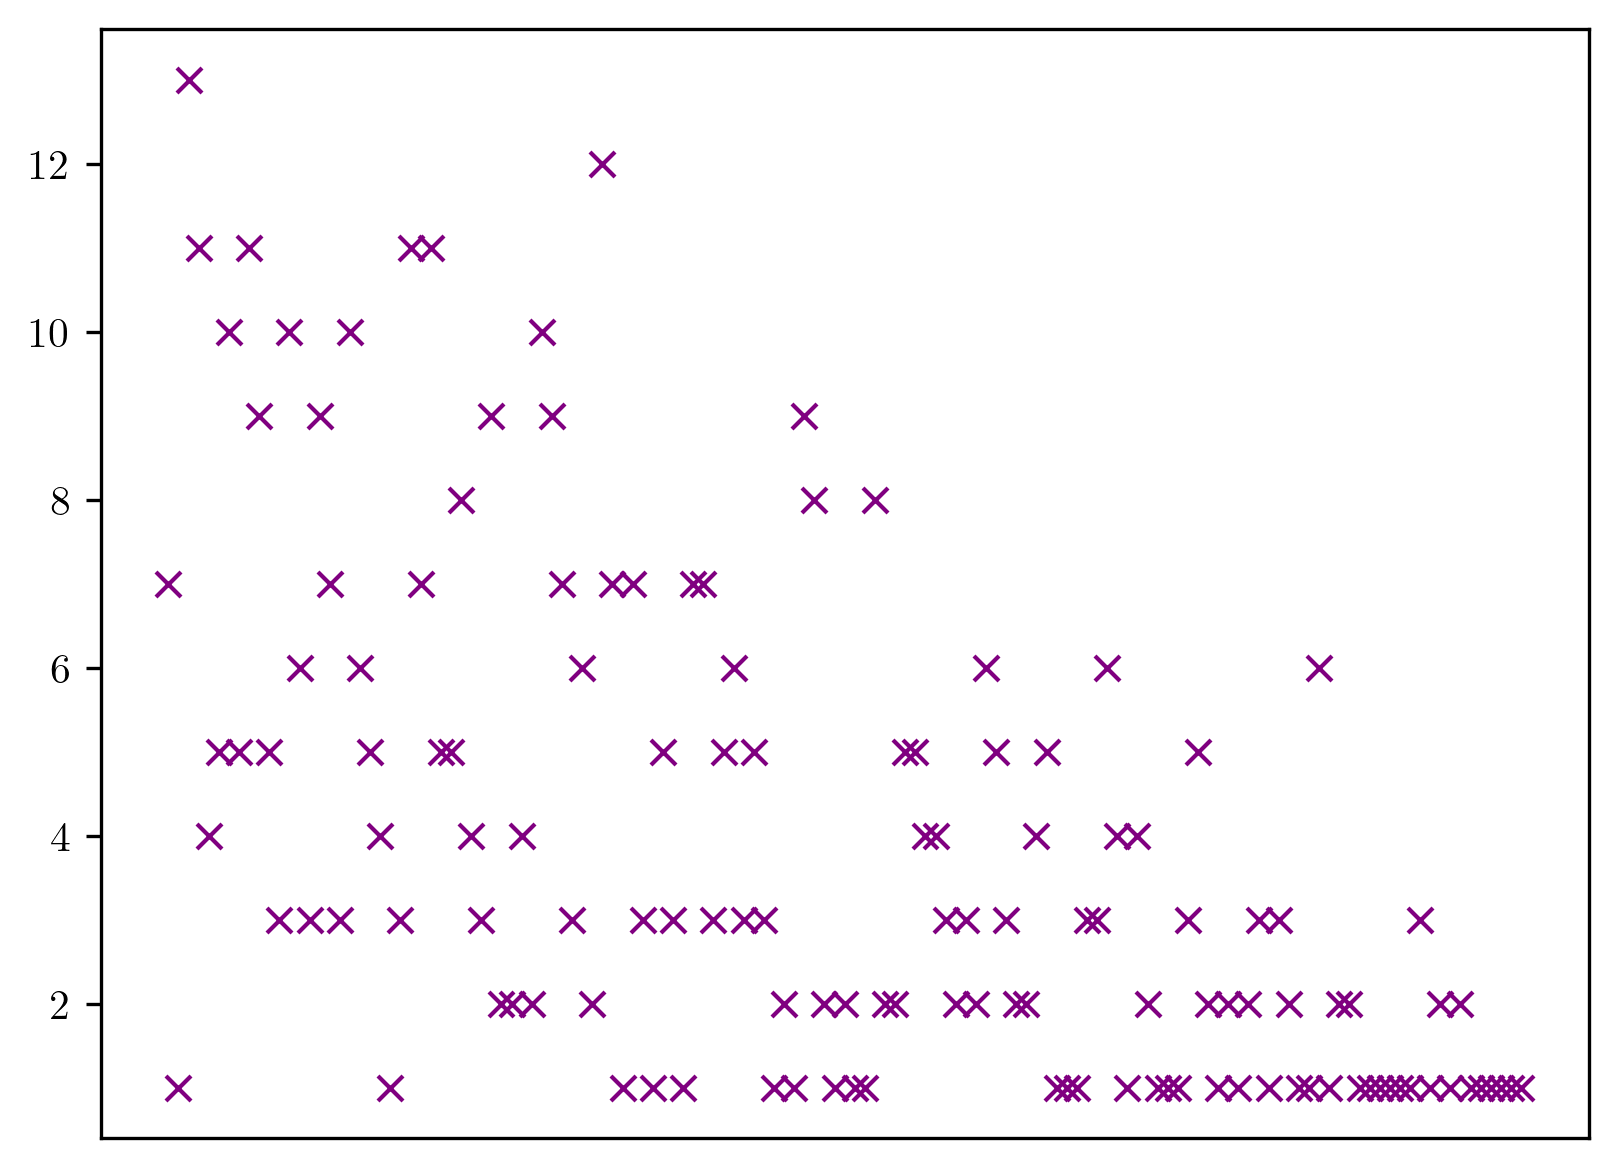

In [759]:
def data_for_k_occupied_sites(data, k):
    return {key: value for key, value in data.items() if key.count('0') == (len(json.loads(key)) - k)}

K = 3
# data_for_k_occupied_sites(reduced_data, 2)
plt.plot(
    list(data_for_k_occupied_sites(reduced_data, K).keys()),
    list(data_for_k_occupied_sites(reduced_data, K).values()),
    'x', markersize=6, color='purple'
)

plt.xlabel(None)
plt.xticks([])

### Simulation of Simplified Problem

In [260]:
class SimpleProblemBounded:
    def __init__(self, num_particles):
        self.num_particles = num_particles
        self.data = [1]*num_particles
    
    def occupied_sites(self):
        indices = []
        for index, value in enumerate(self.data):
            if value != 0:
                indices.append(index)
        return indices
    
    def unoccupied_sites(self):
        indices = []
        for index, value in enumerate(self.data):
            if value == 0:
                indices.append(index)
        return indices
    
    def occupied_neighbors_of_site(self, k):
        occupied_neighbors = []
        left_neighbor = (k - 1) % self.num_particles
        right_neighbor = (k + 1) % self.num_particles
        for neighbor in [left_neighbor, right_neighbor]:
            if self.data[neighbor] != 0:
                occupied_neighbors.append(neighbor)
        return occupied_neighbors
    
    def enumerate_possible_pairs(self):
        pairs = []
        for site in self.occupied_sites():
            for occupied_neighbor in self.occupied_neighbors_of_site(site):
                pairs.append((site, occupied_neighbor))
        return pairs
    
    def hop(self):
        if not self.is_jammed():
            pairs = self.enumerate_possible_pairs()
            choice = random.choice(pairs)
            departure_site, arrival_site = choice
            self.data[departure_site] -= 1
            self.data[arrival_site] += 0
        return self.is_jammed()
    
    def is_jammed(self):
        for site in self.occupied_sites():
            if len(self.occupied_neighbors_of_site(site)) > 0:
                return False
        return True
    
    def hop_until_jammed(self):
        while not self.hop():
            pass        
        return len(self.occupied_sites()) / self.num_particles

In [179]:
Proportions2 = []

for _ in tqdm(range(1000)):
    pr = SimpleProblemBounded(1000)
    prop_filled = pr.hop_until_jammed()
    Proportions2.append(prop_filled)
# pr.data

100%|██████████| 1000/1000 [02:43<00:00,  6.10it/s]


In [275]:
Proportions = []

for _ in tqdm(range(1)):
    pr = Configuration(20_000)
    pr.evolve_until_absorbing_state()
    prop_filled = pr.get_num_of_occupied_sites() / pr.num_of_sites
    Proportions.append(prop_filled)
# pr.data

100%|██████████| 1/1 [01:37<00:00, 97.41s/it]


In [276]:
Proportions

[0.38185]

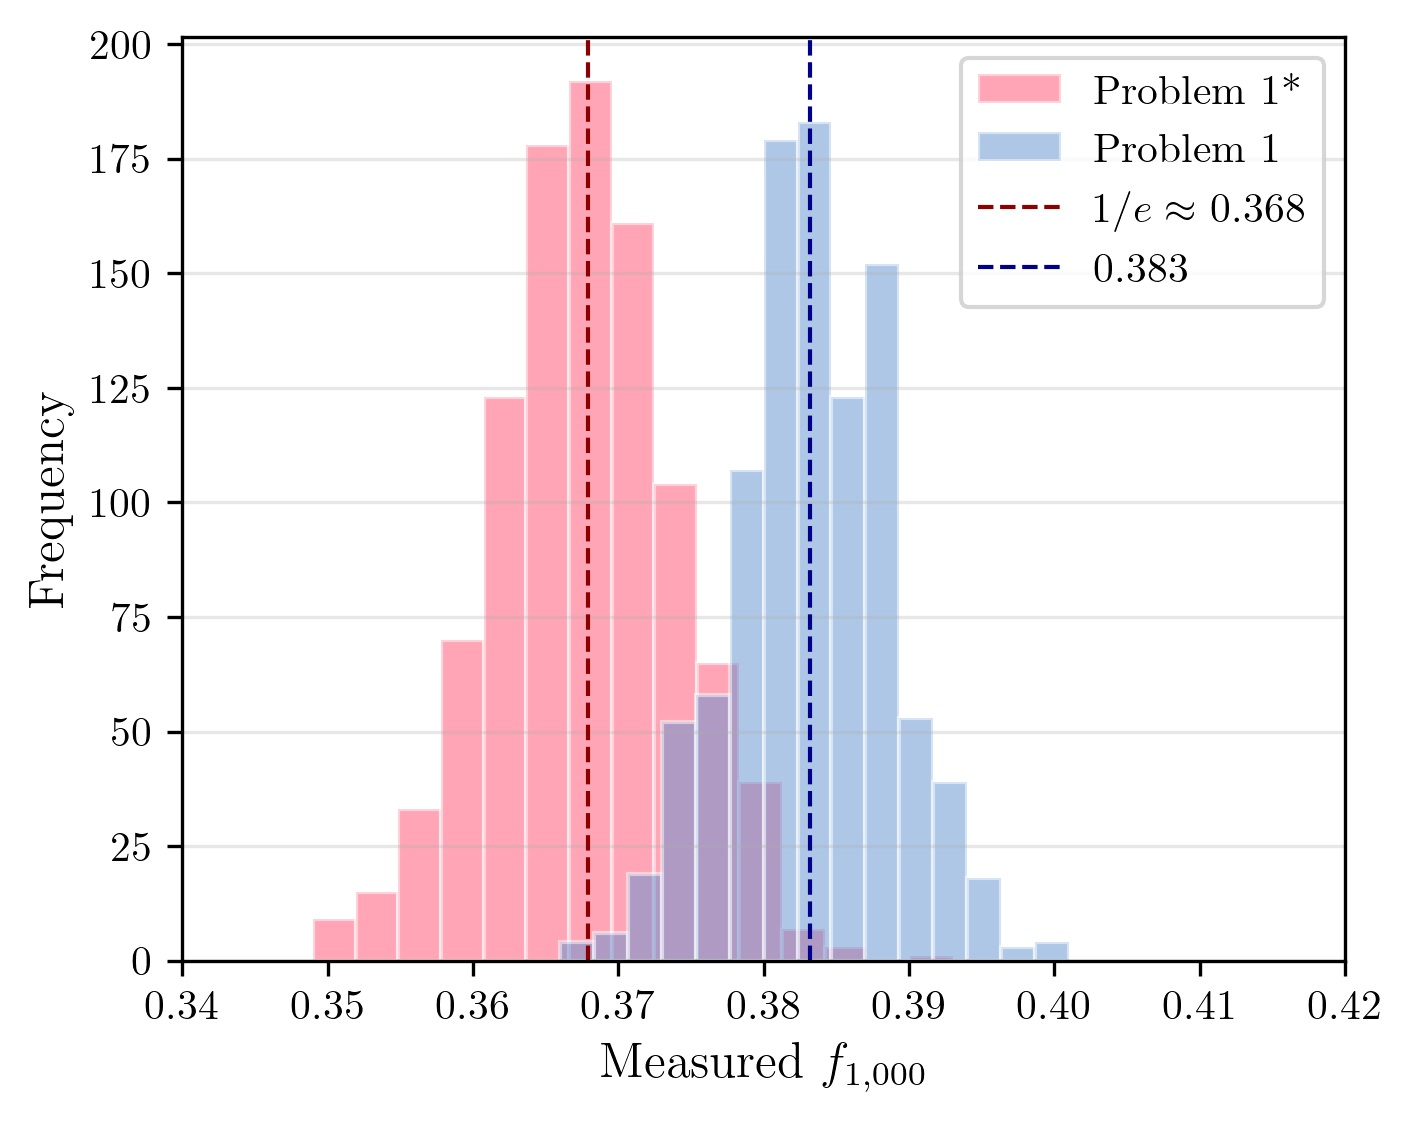

In [226]:
plt.figure(figsize=(5, 4))
plt.hist(Proportions2, bins=15, color='#ff4d6d', edgecolor='white', alpha=0.5, label="Problem 1*")
plt.hist(Proportions, bins=15, color='#5e90d1', edgecolor='white', alpha=0.5, label="Problem 1")
plt.xlabel('Measured $f_{1,000}$', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.axvline(1/np.e, color='darkred', linestyle='--', linewidth=1, label=r'$1/e \approx $ ' + str(round(1/np.exp(1), 3)))
plt.axvline(np.mean(Proportions), color='darkblue', linestyle='--', linewidth=1, label=str(round(np.mean(Proportions), 3)))
plt.legend()
plt.grid(axis='y', alpha=0.3)
plt.xlim(0.34, 0.42)
# plt.tight_layout()
plt.show()

In [229]:
L = 1000
trials = 100

data = []

for __ in tqdm(range(trials)):
    config = TPConfiguration(L, beta=100)
    NumberOfStacks1 = [L]
    Time = 10_000

    for _ in range(Time):
        config.evolve()
        NumberOfStacks1.append(config.get_num_of_occupied_sites())

    data.append(NumberOfStacks1)

100%|██████████| 100/100 [06:31<00:00,  3.92s/it]


In [230]:
np_data = np.array(data)
mean1 = np.mean(np_data, axis=0)
std1 = np.std(np_data, axis=0)

In [236]:
L = 1000
trials = 100

data2 = []

for __ in tqdm(range(trials)):
    config = Configuration(L)
    NumberOfStacks1 = [L]
    Time = 10_000

    for _ in range(Time):
        config.evolve()
        NumberOfStacks1.append(config.get_num_of_occupied_sites())

    data2.append(NumberOfStacks1)

100%|██████████| 100/100 [01:29<00:00,  1.12it/s]


In [237]:
np_data2 = np.array(data2)
mean2 = np.mean(np_data2, axis=0)
std2 = np.std(np_data2, axis=0)

In [265]:
L = 1000
trials = 100

data3 = []

for __ in tqdm(range(trials)):
    config = SimpleProblemBounded(L)
    NumberOfStacks1 = [L]
    Time = 10_000

    for _ in range(Time):
        config.hop()
        NumberOfStacks1.append(len(config.occupied_sites()))

    data3.append(NumberOfStacks1)

100%|██████████| 100/100 [04:03<00:00,  2.44s/it]


In [266]:
np_data3 = np.array(data3)
mean3 = np.mean(np_data3, axis=0)
std3 = np.std(np_data3, axis=0)

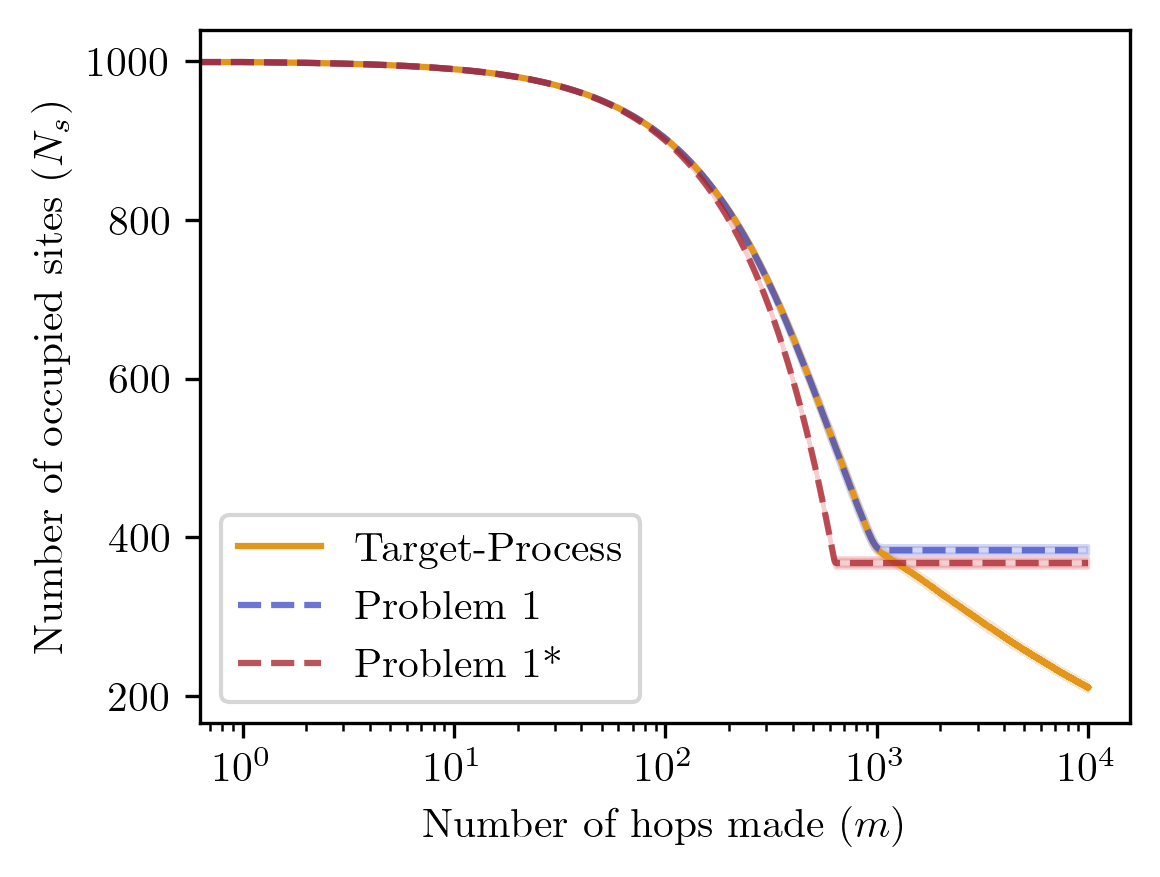

In [271]:
TimeSeries = np.array(list(range(Time + 1)))
plt.figure(figsize=(4, 3))
plt.plot(TimeSeries, mean1, color="#e39619", linewidth=1.5, linestyle='-', label="Target-Process")
plt.fill_between(TimeSeries, mean1 - std1, mean1 + std1, color="#deb676", alpha=0.3)
plt.plot(TimeSeries, mean2, color="#4753c9", linewidth=1.5, linestyle='--', label="Problem 1", alpha=0.8)
plt.fill_between(TimeSeries, mean2 - std2, mean2 + std2, color="#7680de", alpha=0.3)
plt.plot(TimeSeries, mean3, color="#ad2831", linewidth=1.5, linestyle='--', label="Problem 1*", alpha=0.8)
plt.fill_between(TimeSeries, mean3 - std3, mean3 + std3, color="#de5d66", alpha=0.3)
# plt.plot(x, mean, color='red', label='Mean', linewidth=2)
# plt.fill_between(x, mean - std, mean + std, color='red', alpha=0.3, label='±1 Std Dev')
# plt.plot(TimeSeries, 500*np.exp(-0.001*TimeSeries), color=colors[5], linewidth=1)
# plt.yscale('log')
plt.xscale('log')
plt.legend()
plt.xlabel("Number of hops made ($m$)")
plt.ylabel("Number of occupied sites ($N_s$)")
plt.legend()
plt.show()

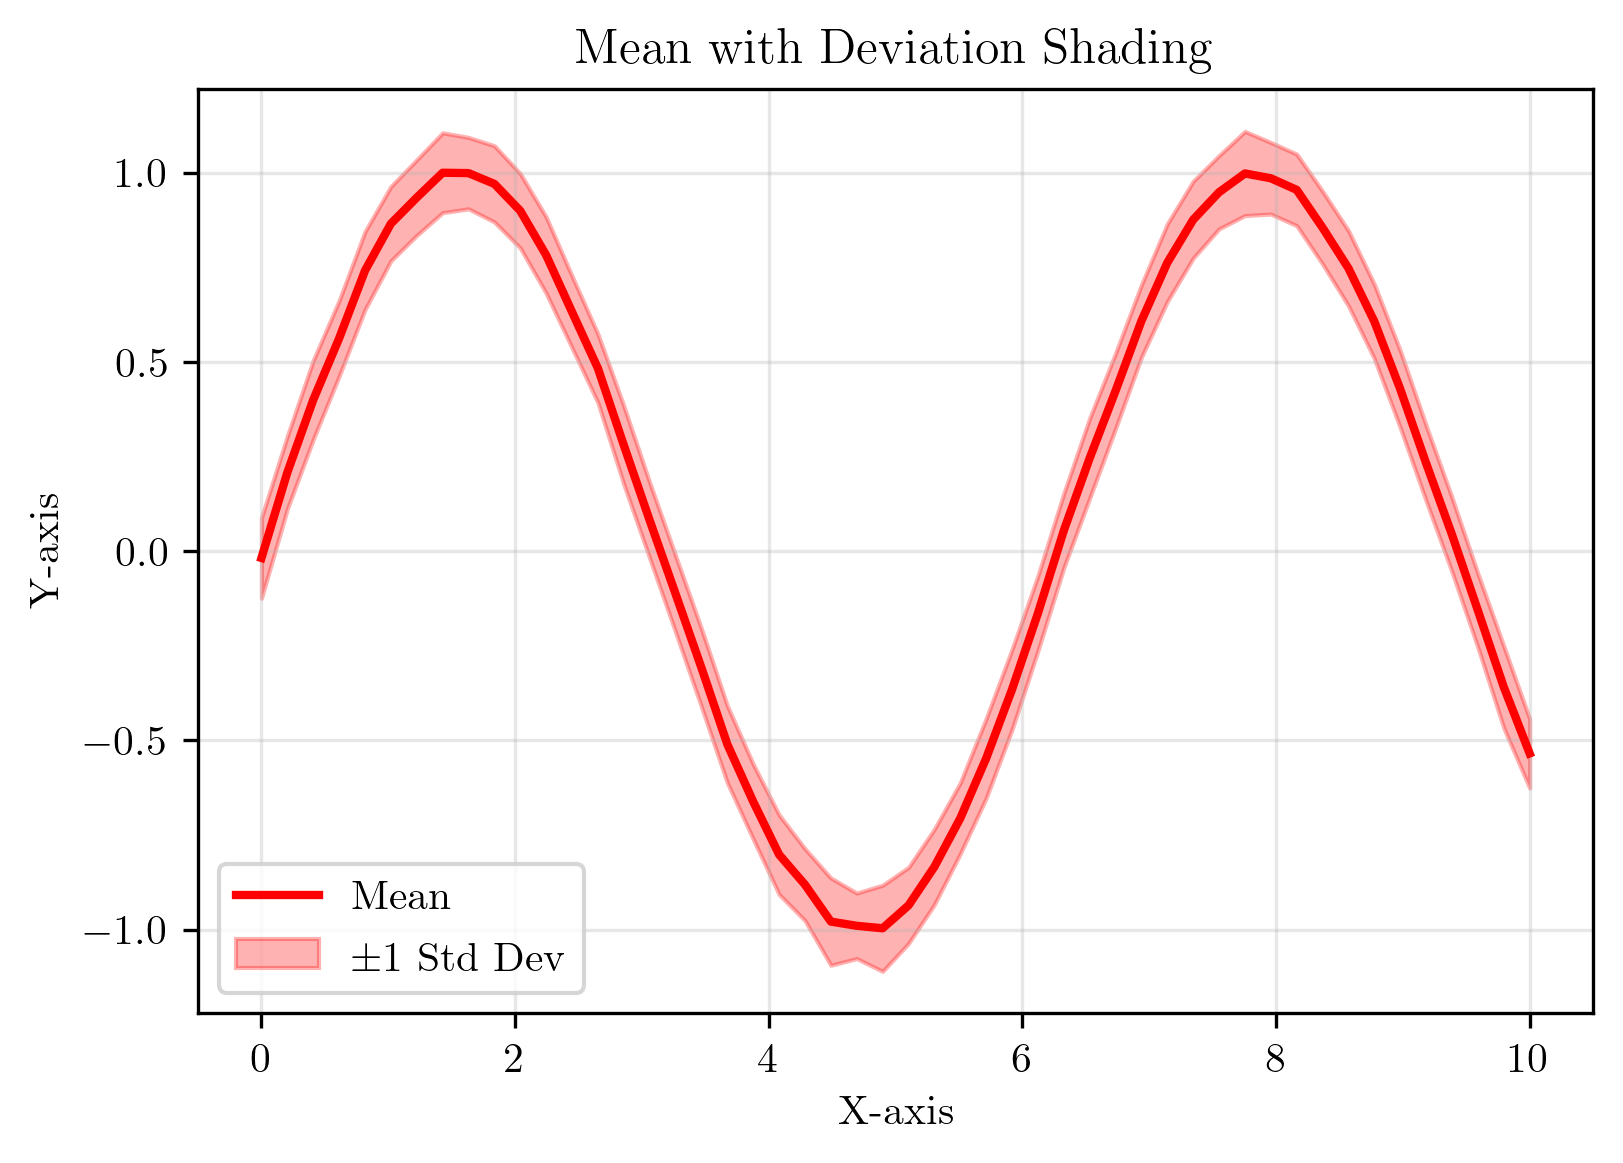

In [209]:
num_trials = 100
num_points = 50
x = np.linspace(0, 10, num_points)
data = np.sin(x) + 0.1 * np.random.randn(num_trials, num_points)  # shape: (100, 50)

# Compute mean and standard deviation across trials
mean = np.mean(data, axis=0)
std = np.std(data, axis=0)

# Plot
plt.figure(figsize=(6, 4))
plt.plot(x, mean, color='red', label='Mean', linewidth=2)
plt.fill_between(x, mean - std, mean + std, color='red', alpha=0.3, label='±1 Std Dev')
plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.legend()
plt.grid(alpha=0.3)
plt.title('Mean with Deviation Shading')
# plt.tight_layout()
plt.show()